In [1]:
import libpysal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from esda.moran import Moran
from scipy.ndimage import gaussian_filter
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split

from GeoConformal import LSCP

In [2]:
def compute_moran(data, grid_size=100):
    w = libpysal.weights.lat2W(grid_size, grid_size)
    w.transform = 'r'  # Row-standardization
    moran = Moran(data, w)
    return moran.I

In [3]:
# Generate a random 50x50 grid
np.random.seed(42)
grid_size = 100
data = np.random.rand(grid_size, grid_size)  # Random values

In [4]:
compute_moran(np.random.uniform(size=(grid_size, grid_size)))

0.0035844302308583745

In [5]:
smooth_data = gaussian_filter(np.random.uniform(0, 6, size=(grid_size, grid_size)), sigma=0.6)
smooth_data_flat = smooth_data.flatten()

In [6]:
compute_moran(smooth_data_flat)

0.4299424175702383

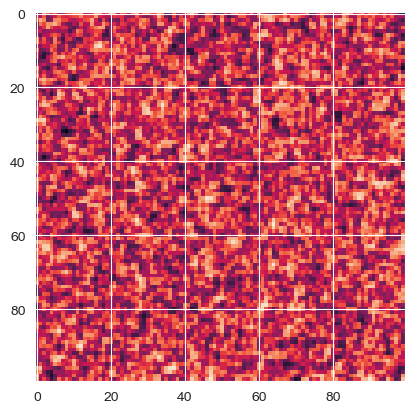

In [7]:
plt.imshow(smooth_data)

In [8]:
base_values = np.random.uniform(10, 20, size=(grid_size, grid_size))

In [9]:
def true_model_predict(X, sigma=0.2):
    smoothed_values = gaussian_filter(base_values, sigma=sigma)
    if isinstance(X, pd.DataFrame):
        X = X.values
    u = X[:, -1].astype(int)
    v = X[:, -2].astype(int)
    return smoothed_values[u, v]

In [10]:
def biased_model_predict(X, noise, sigma=0.2):
    smoothed_values = gaussian_filter(base_values, sigma=sigma) + noise
    if isinstance(X, pd.DataFrame):
        X = X.values
    u = X[:, -1].astype(int)
    v = X[:, -2].astype(int)
    return smoothed_values[u, v]

In [40]:
def biased_model_predict_re(noise, sigma, X):
    smoothed_values = gaussian_filter(base_values, sigma=sigma) + noise
    if isinstance(X, pd.DataFrame):
        X = X.values
    u = X[:, -1].astype(int)
    v = X[:, -2].astype(int)
    return smoothed_values[u, v]

In [11]:
u = np.array([np.linspace(0, grid_size - 1, num=grid_size)] * grid_size).reshape(-1)
v = np.array([np.linspace(0, grid_size - 1, num=grid_size)] * grid_size).T.reshape(-1)
coords = np.array(list(zip(u, v)))

In [12]:
X_coords = pd.DataFrame(coords, columns=['x_coord', 'y_coord'])

In [13]:
loc = X_coords[['x_coord', 'y_coord']]

In [14]:
true_y = true_model_predict(X_coords, sigma=5)

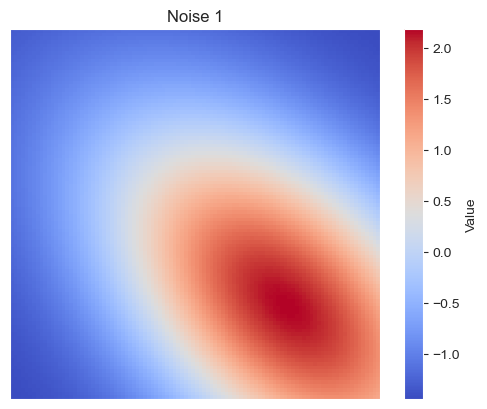

In [15]:
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
mean = [1, 1]
covariance = [[2, 1], [1, 2]]
rv = multivariate_normal(mean, covariance)
n1 = rv.pdf(pos) * 40
n1 = n1 - n1.mean()

X_ = np.arange(0, 100)
Y_ = np.arange(0, 100)
# Plot the distribution
plt.imshow(n1, cmap='coolwarm')
plt.colorbar(label='Value')
plt.title('Noise 1')
plt.xticks([])
plt.yticks([])
plt.savefig('./noise_1.pdf', dpi=300, bbox_inches='tight')
plt.show()

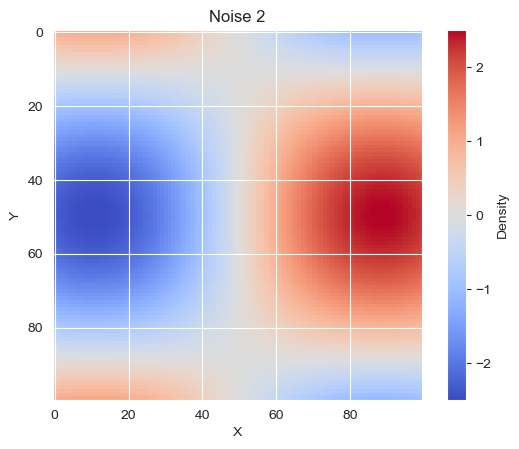

In [16]:
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
n2 = np.sin(X) * np.cos(Y) / 2 * 5
n2 = n2 - n2.mean()

# Plot the distribution
plt.imshow(n2, cmap='coolwarm')
plt.colorbar(label='Density')
plt.title('Noise 2')
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig('./noise_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
biased_y = biased_model_predict(X_coords, n1, sigma=5)

In [18]:
X_train, X_temp, true_y_train, true_y_temp, biased_y_train, biased_y_temp, loc_train, loc_temp = train_test_split(
    X_coords, true_y, biased_y, loc, train_size=0.8)

In [19]:
X_calib, X_test, true_y_calib, true_y_test, biased_y_calib, biased_y_test, loc_calib, loc_test = train_test_split(
    X_temp, true_y_temp, biased_y_temp, loc_temp, train_size=0.5)

In [20]:
from GeoConformal import GeoConformalSpatialRegression

In [21]:
geocp_spatial = GeoConformalSpatialRegression(predict_f=lambda x_: true_model_predict(x_, sigma=0.5),
                                              nonconformity_score_f=None, miscoverage_level=0.1, bandwidth=25,
                                              coord_calib=loc_calib.values, coord_test=loc.values, X_calib=X_calib,
                                              y_calib=true_y_calib, X_test=X_coords, y_test=true_y)

In [22]:
results = geocp_spatial.analyze()

In [23]:
results_geo = results.to_gpd()

In [24]:
results.coverage_probability

0.8774

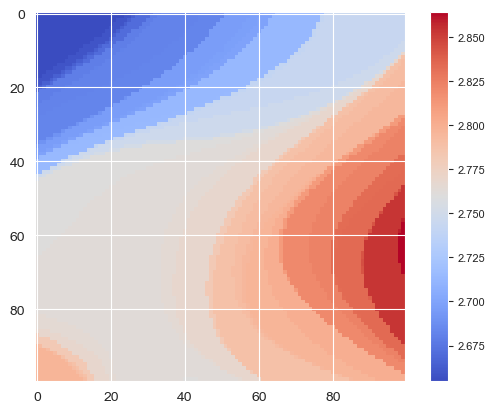

In [25]:
fig, ax = plt.subplots()
c = plt.imshow(results_geo['geo_uncertainty'].values.reshape(100, 100), cmap='coolwarm')
cb = fig.colorbar(c, ax=ax)
cb.ax.tick_params(labelsize=8)
plt.savefig('./true_geo_uncertainty.pdf', dpi=300, bbox_inches='tight')

In [26]:
geocp_spatial_biased = GeoConformalSpatialRegression(predict_f=lambda x_: biased_model_predict(x_, n1, sigma=0.5),
                                                     nonconformity_score_f=None, miscoverage_level=0.1, bandwidth=5,
                                                     coord_calib=loc_calib.values, coord_test=loc.values,
                                                     X_calib=X_calib, y_calib=true_y_calib, X_test=X_coords,
                                                     y_test=true_y)

In [27]:
results_biased = geocp_spatial_biased.analyze()

In [28]:
results_geo_biased = results_biased.to_gpd()

In [29]:
results_biased.coverage_probability

0.8961

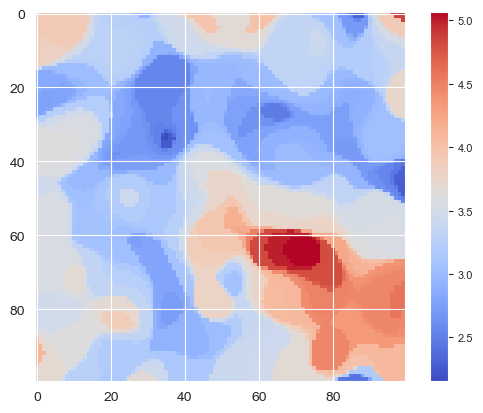

In [30]:
fig, ax = plt.subplots()
c = plt.imshow(results_geo_biased['geo_uncertainty'].values.reshape(100, 100), cmap='coolwarm')
cb = fig.colorbar(c, ax=ax)
cb.ax.tick_params(labelsize=8)
plt.savefig('./noise_1_geo_uncertainty.pdf', dpi=300, bbox_inches='tight')

In [31]:
geocp_spatial_biased = GeoConformalSpatialRegression(predict_f=lambda x_: biased_model_predict(x_, n2, sigma=0.5),
                                                     nonconformity_score_f=None, miscoverage_level=0.1, bandwidth=5,
                                                     coord_calib=loc_calib.values, coord_test=loc.values,
                                                     X_calib=X_calib, y_calib=true_y_calib, X_test=X_coords,
                                                     y_test=true_y)

In [32]:
results_biased = geocp_spatial_biased.analyze()

In [33]:
results_geo_biased = results_biased.to_gpd()

In [34]:
results_biased.coverage_probability

0.8833

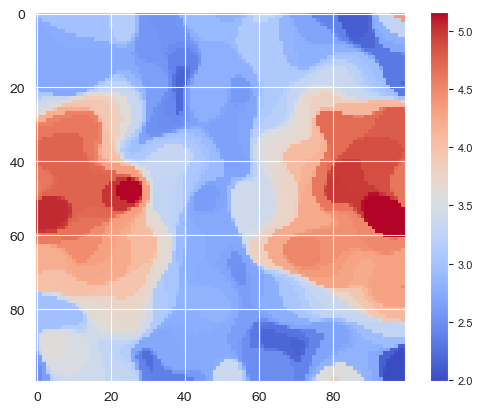

In [35]:
fig, ax = plt.subplots()
c = plt.imshow(results_geo_biased['geo_uncertainty'].values.reshape(100, 100), cmap='coolwarm')
cb = fig.colorbar(c, ax=ax)
cb.ax.tick_params(labelsize=8)
plt.savefig('./noise_2_geo_uncertainty.pdf', dpi=300, bbox_inches='tight')

In [36]:
base_noise = np.random.normal(0, 0.75, size=(100, 100))


def generate_noise(sigma=0.2):
    smoothed_noise = gaussian_filter(base_noise, sigma=sigma)
    return smoothed_noise

In [37]:
base_noise.max()

2.5260101454330144

In [38]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from skimage.metrics import structural_similarity

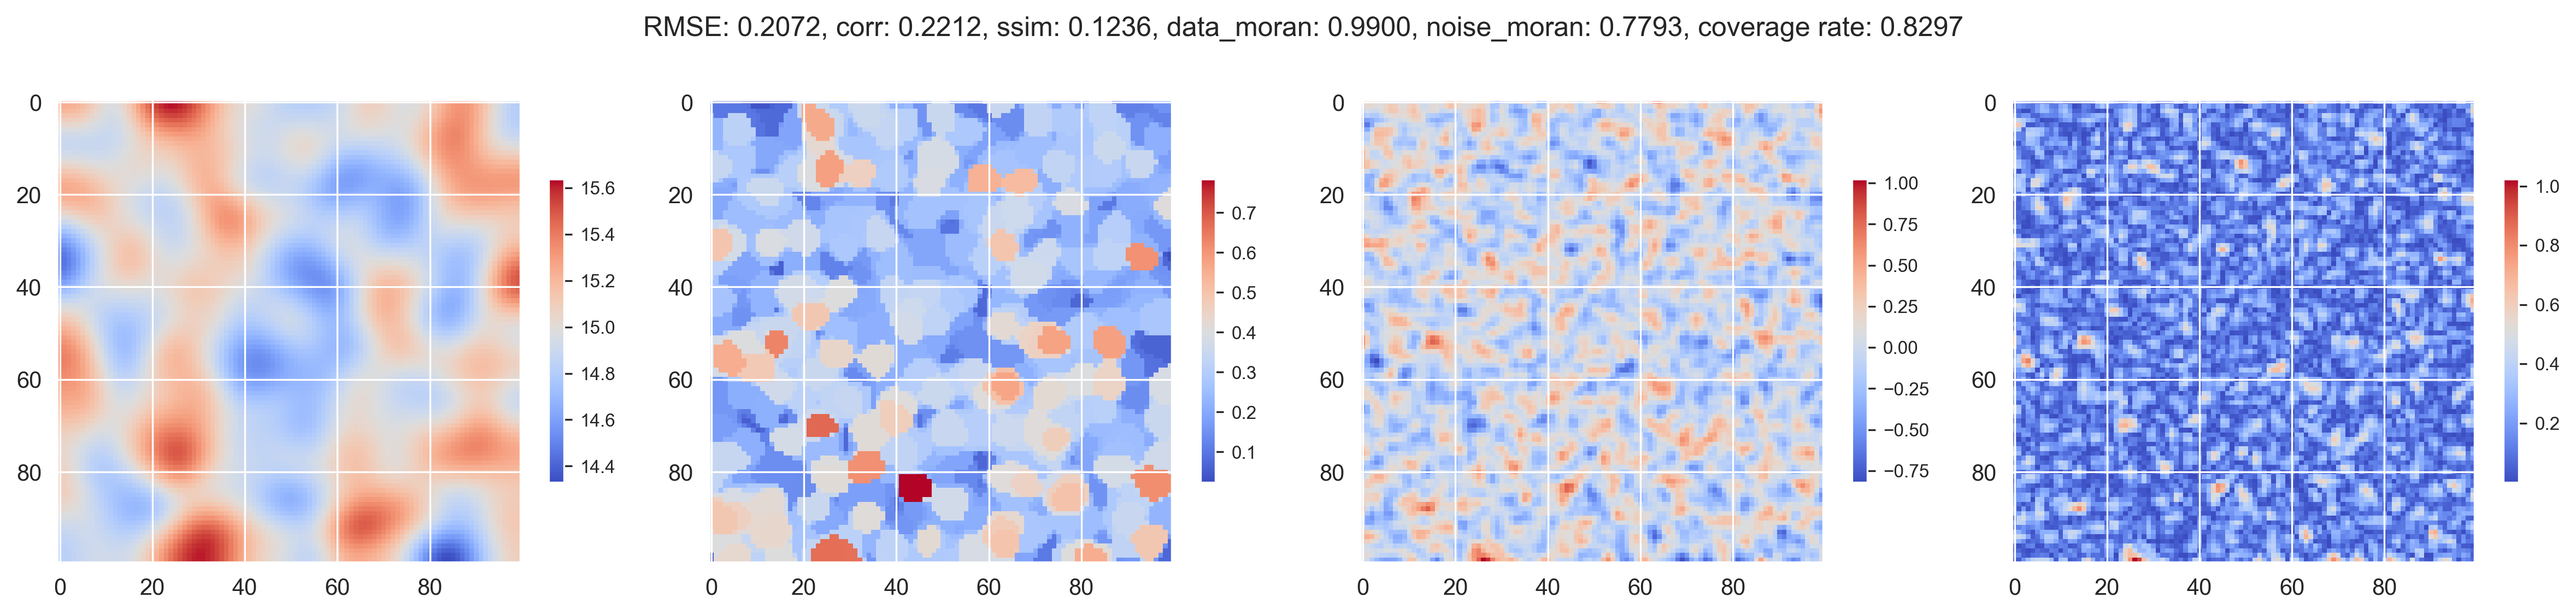

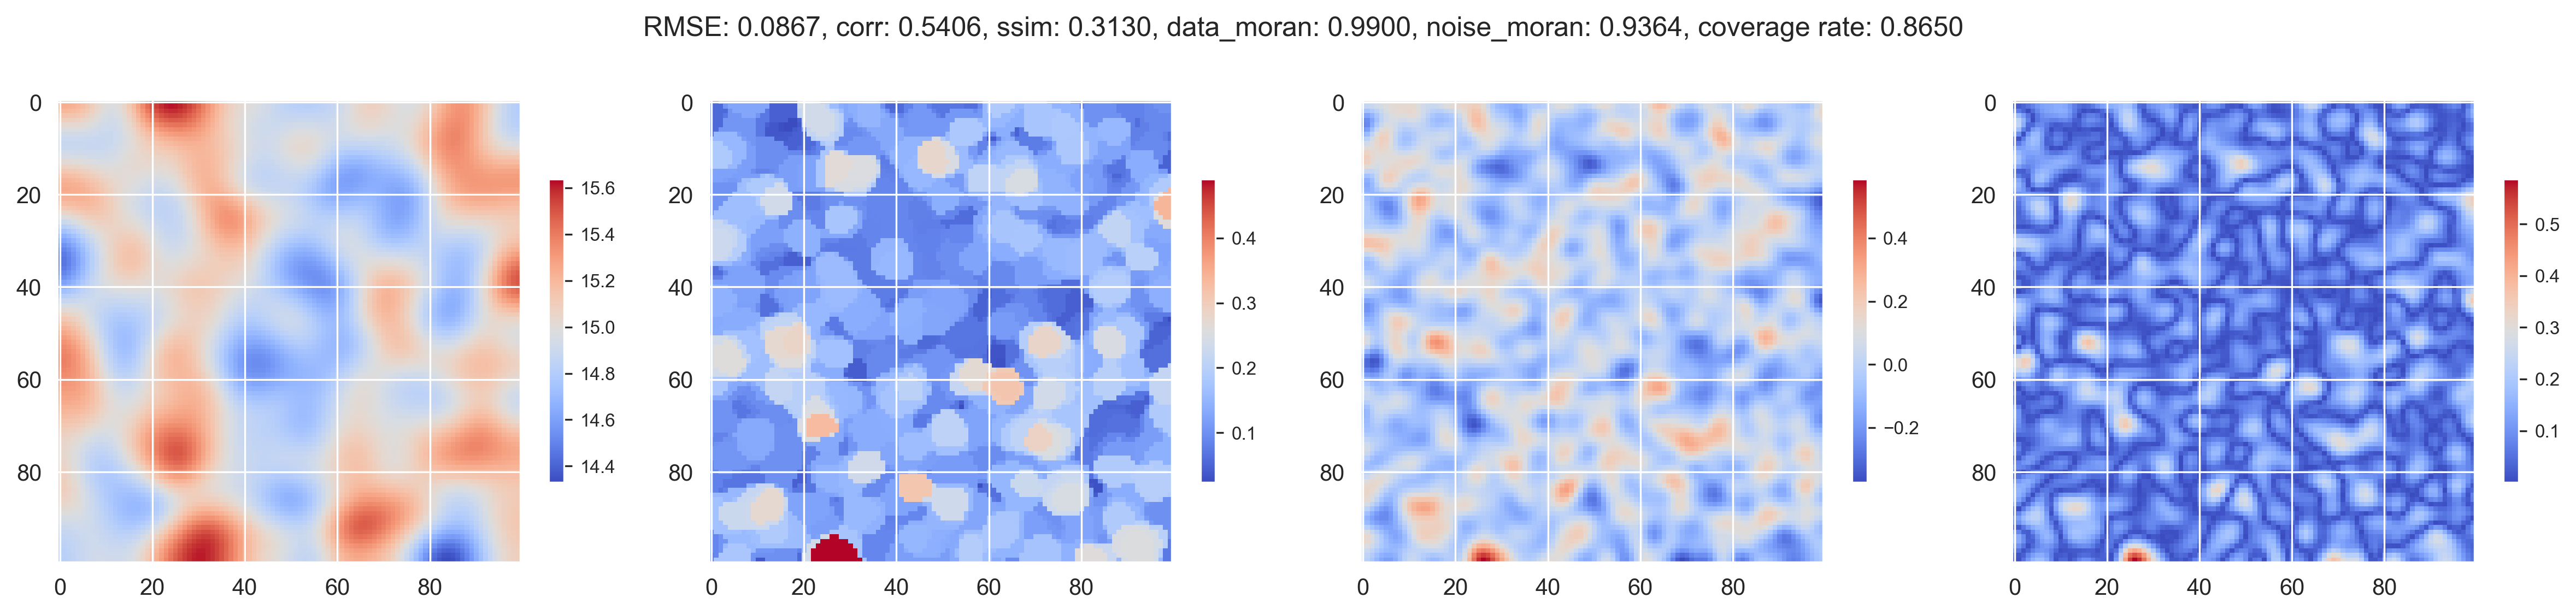

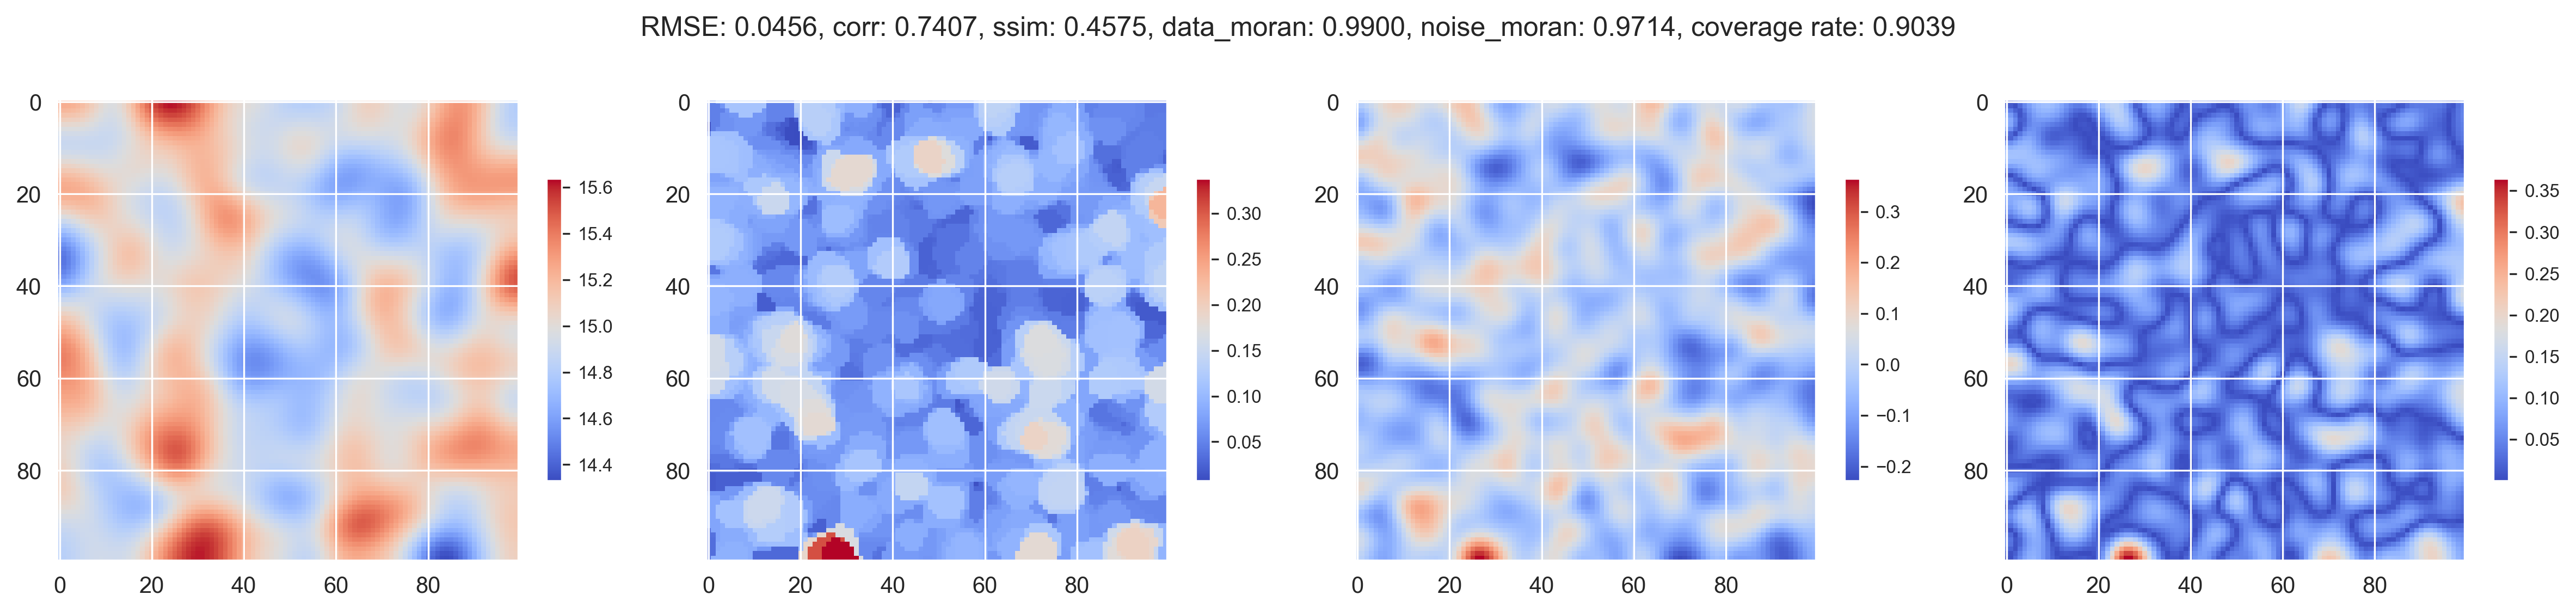

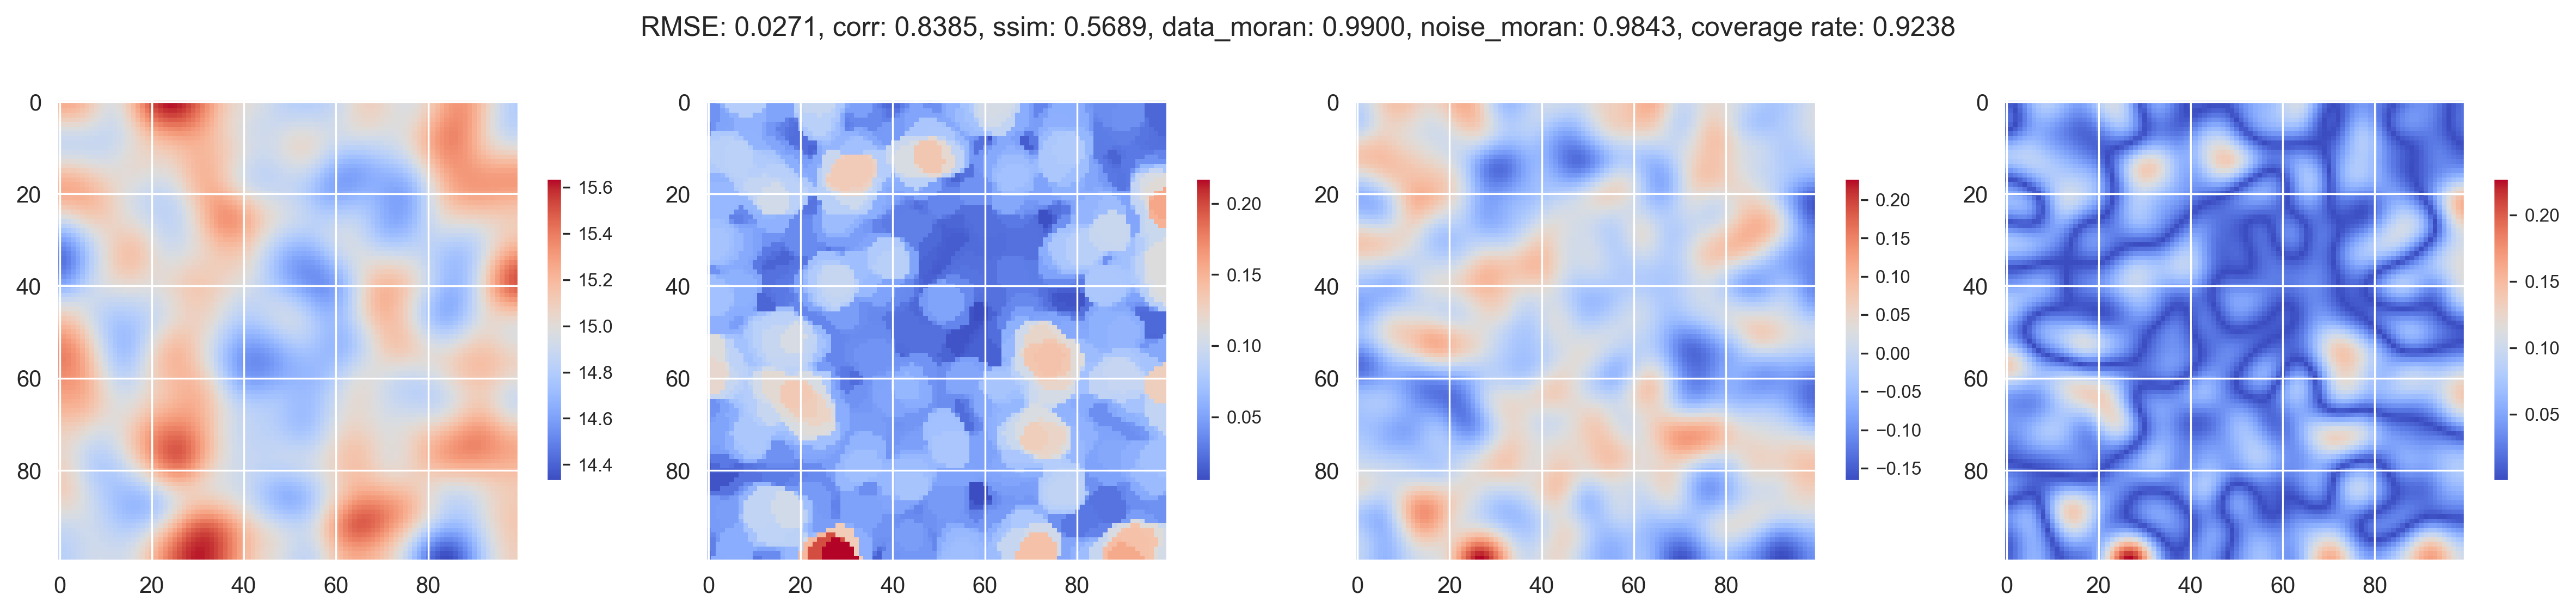

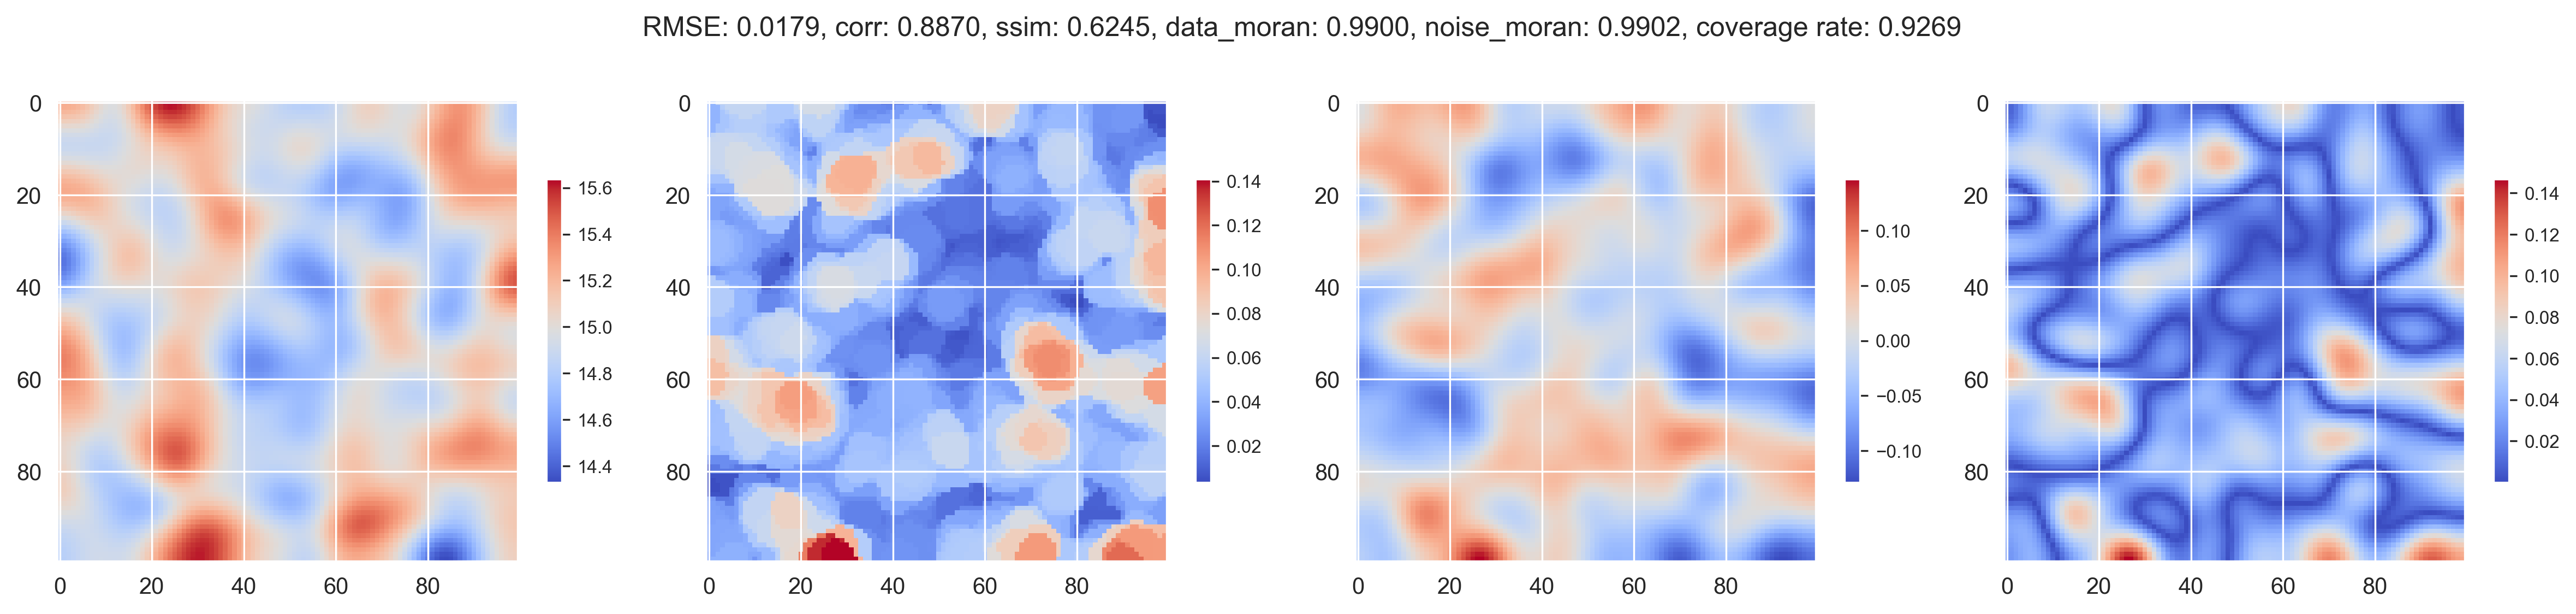

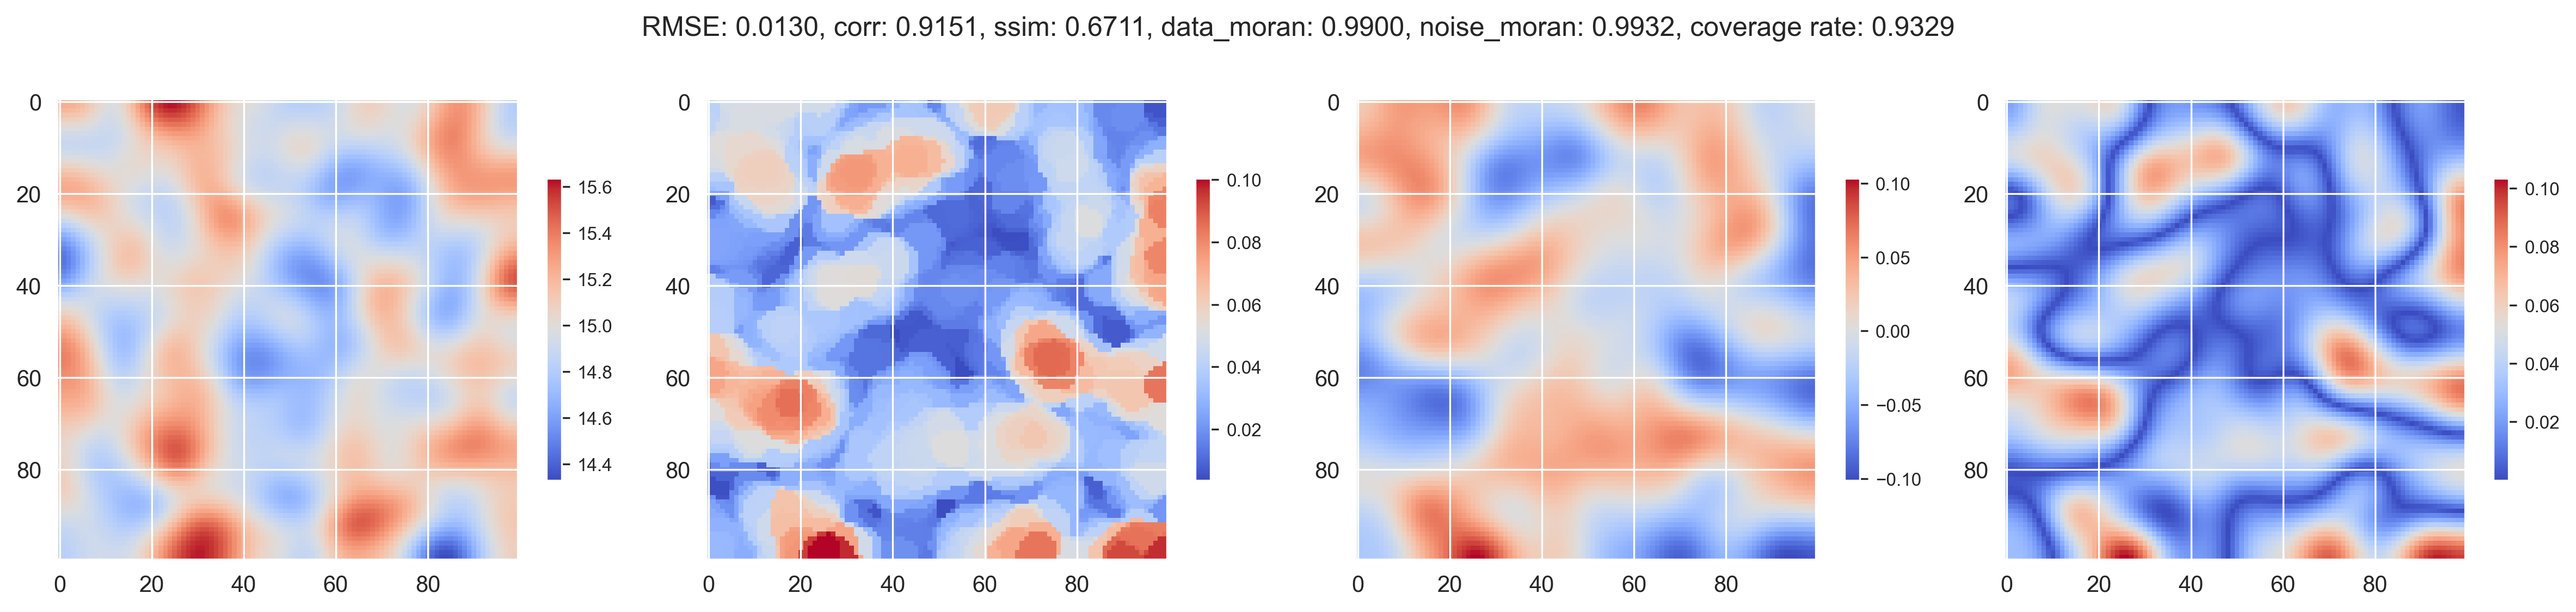

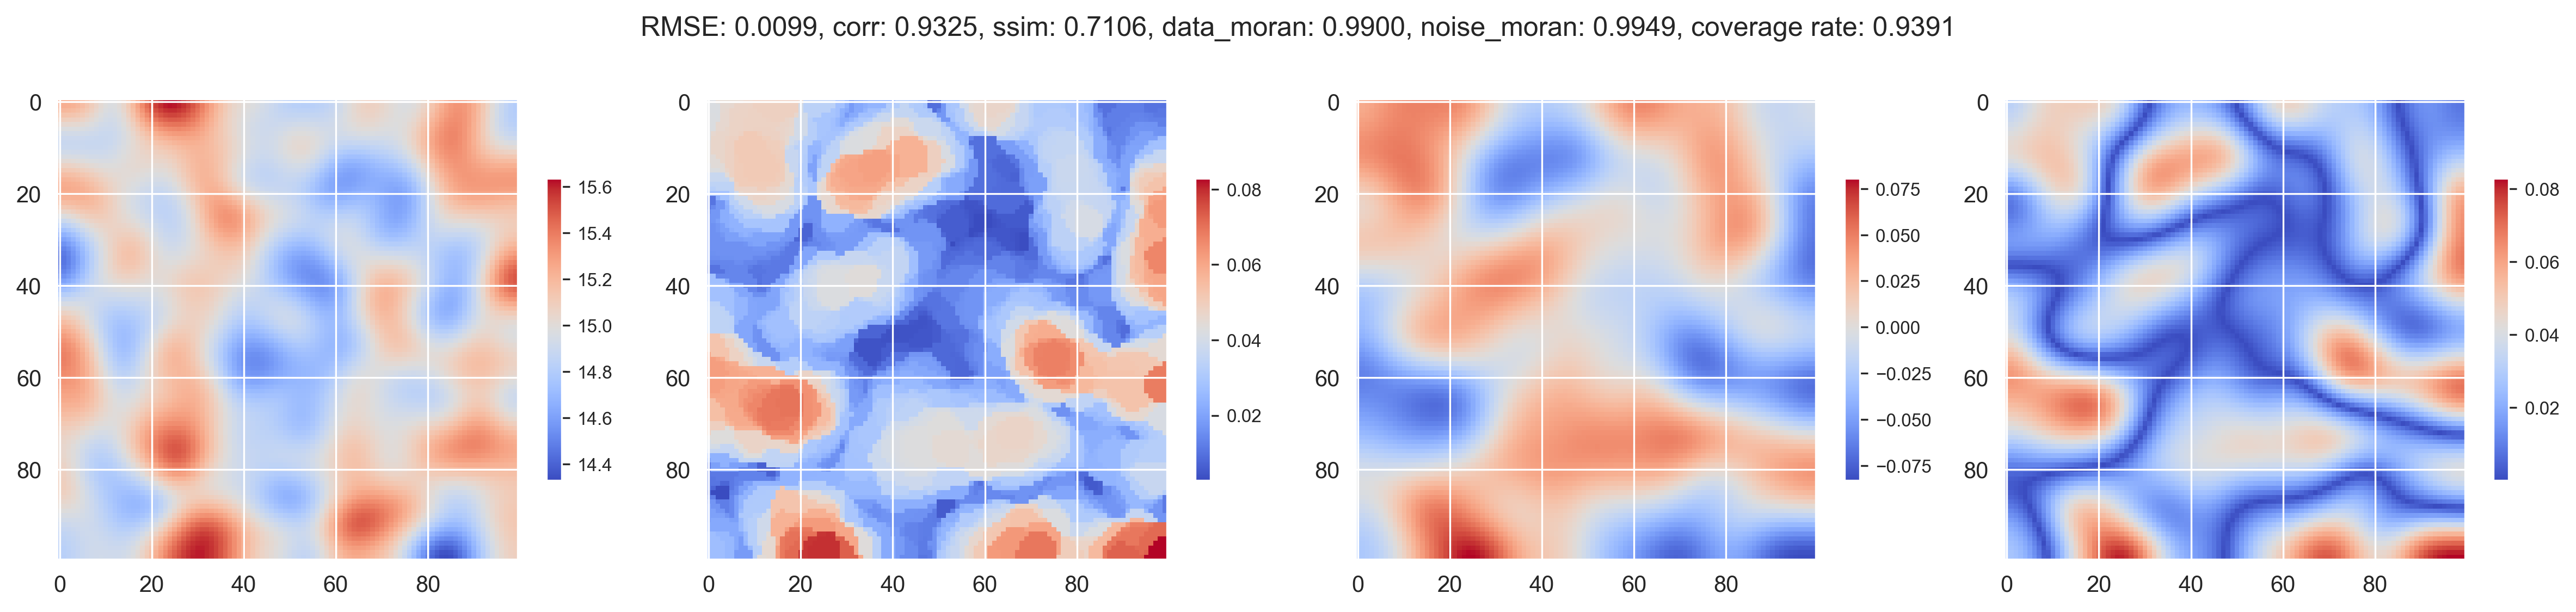

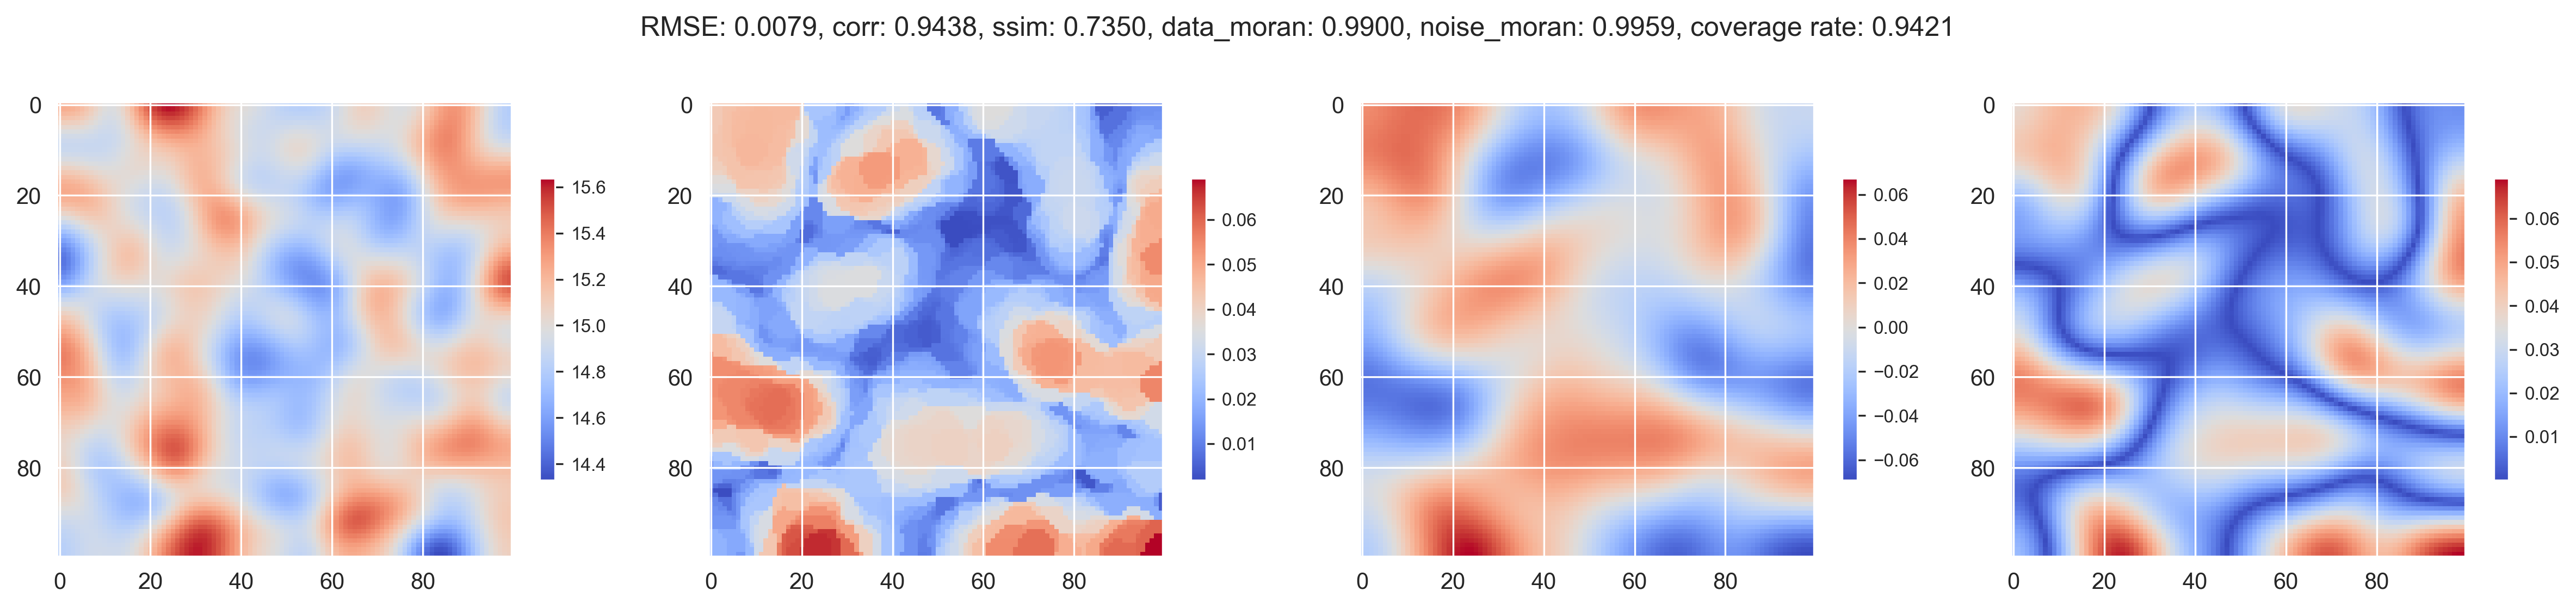

In [39]:
noise_sigmas = [1, 2, 3, 4, 5, 6, 7, 8]

for noise_sigma in noise_sigmas:
    noise = generate_noise(noise_sigma)
    geocp_spatial_biased = GeoConformalSpatialRegression(predict_f=lambda x_: biased_model_predict(x_, noise, sigma=5),
                                                         nonconformity_score_f=None, miscoverage_level=0.1, bandwidth=2,
                                                         coord_calib=loc_calib.values, coord_test=loc.values,
                                                         X_calib=X_calib, y_calib=true_y_calib, X_test=X_coords,
                                                         y_test=true_y)
    results_biased = geocp_spatial_biased.analyze()
    results_geo_biased = results_biased.to_gpd()
    geo_uncertainty = results_geo_biased.geo_uncertainty
    geo_uncertainty = geo_uncertainty.values.reshape(100, 100)
    coverage_rate = results_biased.coverage_probability
    fig, axes = plt.subplots(1, 4, dpi=300, figsize=(16, 4))
    ax1, ax2, ax3, ax4 = axes
    c1 = ax1.imshow(true_y.reshape(100, 100), cmap='coolwarm')
    cb1 = fig.colorbar(c1, ax=ax1, shrink=0.5)
    cb1.ax.tick_params(labelsize=8)
    c2 = ax2.imshow(geo_uncertainty, cmap='coolwarm')
    cb2 = fig.colorbar(c2, ax=ax2, shrink=0.5)
    cb2.ax.tick_params(labelsize=8)
    c3 = ax3.imshow(noise, cmap='coolwarm')
    cb3 = fig.colorbar(c3, ax=ax3, shrink=0.5)
    cb3.ax.tick_params(labelsize=8)
    noise_abs = np.abs(noise)
    c4 = ax4.imshow(np.abs(noise), cmap='coolwarm')
    cb4 = fig.colorbar(c4, ax=ax4, shrink=0.5)
    cb4.ax.tick_params(labelsize=8)
    noise_moran_i = compute_moran(noise)
    data_moran_i = compute_moran(true_y.reshape(100, 100))
    rmse = root_mean_squared_error(noise_abs, geo_uncertainty)
    corr = np.corrcoef(noise_abs.flatten(), geo_uncertainty.flatten())[0, 1]
    ssim = structural_similarity(noise_abs, geo_uncertainty, data_range=noise_abs.max() - noise_abs.min())
    plt.tight_layout()
    fig.suptitle(
        f'RMSE: {rmse:.4f}, corr: {corr:.4f}, ssim: {ssim:.4f}, data_moran: {data_moran_i:.4f}, noise_moran: {noise_moran_i:.4f}, coverage rate: {coverage_rate:.4f}')
    plt.savefig(f'./noise_moran/sigma_{noise_sigma}.pdf', dpi=300)

In [41]:
noise_sigmas = [0.2, 0.4, 0.8, 1, 2, 3, 4, 5, 6]
noise = generate_noise(5)

for noise_sigma in noise_sigmas:
    true_y = true_model_predict(X_coords, sigma=noise_sigma)
    X_train, X_temp, true_y_train, true_y_temp, biased_y_train, biased_y_temp, loc_train, loc_temp = train_test_split(
        X_coords, true_y, biased_y, loc, train_size=0.8)
    X_calib, X_test, true_y_calib, true_y_test, biased_y_calib, biased_y_test, loc_calib, loc_test = train_test_split(
        X_temp, true_y_temp, biased_y_temp, loc_temp, train_size=0.5)
    geocp_spatial_biased = GeoConformalSpatialRegression(
        predict_f=lambda x_: biased_model_predict(x_, noise, sigma=noise_sigma), nonconformity_score_f=None,
        miscoverage_level=0.1, bandwidth=2, coord_calib=loc_calib.values, coord_test=loc.values, X_calib=X_calib,
        y_calib=true_y_calib, X_test=X_coords, y_test=true_y)
    results_biased = geocp_spatial_biased.analyze()
    results_geo_biased = results_biased.to_gpd()
    geo_uncertainty = results_geo_biased.geo_uncertainty
    geo_uncertainty = geo_uncertainty.values.reshape(100, 100)
    coverage_rate = results_biased.coverage_probability
    fig, axes = plt.subplots(1, 4, dpi=300, figsize=(16, 4))
    ax1, ax2, ax3, ax4 = axes
    c1 = ax1.imshow(true_y.reshape(100, 100), cmap='coolwarm')
    cb1 = fig.colorbar(c1, ax=ax1, shrink=0.5)
    cb1.ax.tick_params(labelsize=8)
    c2 = ax2.imshow(geo_uncertainty, cmap='coolwarm')
    cb2 = fig.colorbar(c2, ax=ax2, shrink=0.5)
    cb2.ax.tick_params(labelsize=8)
    c3 = ax3.imshow(noise, cmap='coolwarm')
    cb3 = fig.colorbar(c3, ax=ax3, shrink=0.5)
    cb3.ax.tick_params(labelsize=8)
    noise_abs = np.abs(noise)
    c4 = ax4.imshow(np.abs(noise), cmap='coolwarm')
    cb4 = fig.colorbar(c4, ax=ax4, shrink=0.5)
    cb4.ax.tick_params(labelsize=8)
    noise_moran_i = compute_moran(noise)
    data_moran_i = compute_moran(true_y.reshape(100, 100))
    rmse = root_mean_squared_error(noise_abs, geo_uncertainty)
    corr = np.corrcoef(noise_abs.flatten(), geo_uncertainty.flatten())[0, 1]
    ssim = structural_similarity(noise_abs, geo_uncertainty, data_range=noise_abs.max() - noise_abs.min())
    plt.tight_layout()
    fig.suptitle(
        f'RMSE: {rmse:.4f}, corr: {corr:.4f}, ssim: {ssim:.4f}, data_moran: {data_moran_i:.4f}, noise_moran: {noise_moran_i:.4f}, coverage rate: {coverage_rate:.4f}')
    plt.savefig(f'./noise_moran/sigma_{noise_sigma}_data.pdf', dpi=300)
    plt.close()

In [45]:
checkerboard = np.indices((grid_size, grid_size)).sum(axis=0) % 2 + 15

In [46]:
checkerboard.max()

16

In [47]:
adjust = np.random.uniform(-5, 5, size=(100, 100))

In [48]:
checkerboard_re = checkerboard + gaussian_filter(adjust, sigma=2)

In [49]:
def true_model_neg_predict(X, sigma, k):
    adjusted_values = checkerboard + k * gaussian_filter(adjust, sigma=sigma)
    if isinstance(X, pd.DataFrame):
        X = X.values
    u = X[:, -1].astype(int)
    v = X[:, -2].astype(int)
    return adjusted_values[u, v]

In [50]:
def biased_model_neg_predict(X, noise, k, sigma):
    adjusted_values = checkerboard + k * gaussian_filter(adjust, sigma=sigma) + noise
    if isinstance(X, pd.DataFrame):
        X = X.values
    u = X[:, -1].astype(int)
    v = X[:, -2].astype(int)
    return adjusted_values[u, v]

In [51]:
def biased_model_neg_predict_re(noise, k, sigma, X):
    adjusted_values = checkerboard + k * gaussian_filter(adjust, sigma=sigma) + noise
    if isinstance(X, pd.DataFrame):
        X = X.values
    u = X[:, -1].astype(int)
    v = X[:, -2].astype(int)
    return adjusted_values[u, v]

In [48]:
noise_sigmas = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# noise_sigmas = [0]
noise = generate_noise(5)

for noise_sigma in noise_sigmas:
    k = 0 if noise_sigma == 0 else 1
    cmap = 'binary' if noise_sigma == 0 else 'coolwarm'
    true_y = true_model_neg_predict(X_coords, sigma=noise_sigma, k=k)
    X_train, X_temp, true_y_train, true_y_temp, biased_y_train, biased_y_temp, loc_train, loc_temp = train_test_split(
        X_coords, true_y, biased_y, loc, train_size=0.8)
    X_calib, X_test, true_y_calib, true_y_test, biased_y_calib, biased_y_test, loc_calib, loc_test = train_test_split(
        X_temp, true_y_temp, biased_y_temp, loc_temp, train_size=0.5)
    geocp_spatial_biased = GeoConformalSpatialRegression(
        predict_f=lambda x_: biased_model_neg_predict(x_, noise, sigma=noise_sigma, k=k), nonconformity_score_f=None,
        miscoverage_level=0.1, bandwidth=2, coord_calib=loc_calib.values, coord_test=loc.values, X_calib=X_calib,
        y_calib=true_y_calib, X_test=X_coords, y_test=true_y)
    results_biased = geocp_spatial_biased.analyze()
    results_geo_biased = results_biased.to_gpd()
    geo_uncertainty = results_geo_biased.geo_uncertainty
    geo_uncertainty = geo_uncertainty.values.reshape(100, 100)
    coverage_rate = results_biased.coverage_probability
    fig, axes = plt.subplots(1, 4, dpi=300, figsize=(16, 4))
    ax1, ax2, ax3, ax4 = axes
    c1 = ax1.imshow(true_y.reshape(100, 100), cmap='coolwarm')
    cb1 = fig.colorbar(c1, ax=ax1, shrink=0.5)
    cb1.ax.tick_params(labelsize=8)
    c2 = ax2.imshow(geo_uncertainty, cmap='coolwarm')
    cb2 = fig.colorbar(c2, ax=ax2, shrink=0.5)
    cb2.ax.tick_params(labelsize=8)
    c3 = ax3.imshow(noise, cmap='coolwarm')
    cb3 = fig.colorbar(c3, ax=ax3, shrink=0.5)
    cb3.ax.tick_params(labelsize=8)
    noise_abs = np.abs(noise)
    c4 = ax4.imshow(np.abs(noise), cmap='coolwarm')
    cb4 = fig.colorbar(c4, ax=ax4, shrink=0.5)
    cb4.ax.tick_params(labelsize=8)
    noise_moran_i = compute_moran(noise)
    data_moran_i = compute_moran(true_y.reshape(100, 100))
    rmse = root_mean_squared_error(noise_abs, geo_uncertainty)
    corr = np.corrcoef(noise_abs.flatten(), geo_uncertainty.flatten())[0, 1]
    ssim = structural_similarity(noise_abs, geo_uncertainty, data_range=noise_abs.max() - noise_abs.min())
    plt.tight_layout()
    fig.suptitle(
        f'RMSE: {rmse:.4f}, corr: {corr:.4f}, ssim: {ssim:.4f}, data_moran: {data_moran_i:.4f}, noise_moran: {noise_moran_i:.4f}, coverage rate: {coverage_rate:.4f}')
    plt.savefig(f'./noise_moran/sigma_{noise_sigma}_neg_data.pdf', dpi=300)
    plt.close()

In [49]:
noise_sigmas = [1, 2, 3, 4, 5, 6, 7, 8]

for noise_sigma in noise_sigmas:
    true_y = true_model_neg_predict(X_coords, sigma=5, k=1)
    X_train, X_temp, true_y_train, true_y_temp, biased_y_train, biased_y_temp, loc_train, loc_temp = train_test_split(
        X_coords, true_y, biased_y, loc, train_size=0.8)
    X_calib, X_test, true_y_calib, true_y_test, biased_y_calib, biased_y_test, loc_calib, loc_test = train_test_split(
        X_temp, true_y_temp, biased_y_temp, loc_temp, train_size=0.5)
    noise = generate_noise(noise_sigma)
    geocp_spatial_biased = GeoConformalSpatialRegression(
        predict_f=lambda x_: biased_model_neg_predict(x_, noise, sigma=5, k=1), nonconformity_score_f=None,
        miscoverage_level=0.1, bandwidth=2, coord_calib=loc_calib.values, coord_test=loc.values, X_calib=X_calib,
        y_calib=true_y_calib, X_test=X_coords, y_test=true_y)
    results_biased = geocp_spatial_biased.analyze()
    results_geo_biased = results_biased.to_gpd()
    geo_uncertainty = results_geo_biased.geo_uncertainty
    geo_uncertainty = geo_uncertainty.values.reshape(100, 100)
    coverage_rate = results_biased.coverage_probability
    fig, axes = plt.subplots(1, 4, dpi=300, figsize=(16, 4))
    ax1, ax2, ax3, ax4 = axes
    c1 = ax1.imshow(true_y.reshape(100, 100), cmap='coolwarm')
    cb1 = fig.colorbar(c1, ax=ax1, shrink=0.5)
    cb1.ax.tick_params(labelsize=8)
    c2 = ax2.imshow(geo_uncertainty, cmap='coolwarm')
    cb2 = fig.colorbar(c2, ax=ax2, shrink=0.5)
    cb2.ax.tick_params(labelsize=8)
    c3 = ax3.imshow(noise, cmap='coolwarm')
    cb3 = fig.colorbar(c3, ax=ax3, shrink=0.5)
    cb3.ax.tick_params(labelsize=8)
    noise_abs = np.abs(noise)
    c4 = ax4.imshow(np.abs(noise), cmap='coolwarm')
    cb4 = fig.colorbar(c4, ax=ax4, shrink=0.5)
    cb4.ax.tick_params(labelsize=8)
    noise_moran_i = compute_moran(noise)
    data_moran_i = compute_moran(true_y.reshape(100, 100))
    rmse = root_mean_squared_error(noise_abs, geo_uncertainty)
    corr = np.corrcoef(noise_abs.flatten(), geo_uncertainty.flatten())[0, 1]
    ssim = structural_similarity(noise_abs, geo_uncertainty, data_range=noise_abs.max() - noise_abs.min())
    plt.tight_layout()
    fig.suptitle(
        f'RMSE: {rmse:.4f}, corr: {corr:.4f}, ssim: {ssim:.4f}, data_moran: {data_moran_i:.4f}, noise_moran: {noise_moran_i:.4f}, coverage rate: {coverage_rate:.4f}')
    plt.savefig(f'./noise_moran/sigma_{noise_sigma}_neg.pdf', dpi=300)
    plt.close()

In [45]:
checkerboard_noise = ((np.indices((grid_size, grid_size)).sum(axis=0) % 2) * 2 - 1) * 2


def neg_noise_generation(sigma, k):
    adjusted_values = checkerboard_noise + k * gaussian_filter(adjust, sigma=sigma)
    return adjusted_values

In [51]:
noise_sigmas = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for noise_sigma in noise_sigmas:
    k = 0 if noise_sigma == 0 else 1
    true_y = true_model_predict(X_coords, sigma=5)
    X_train, X_temp, true_y_train, true_y_temp, biased_y_train, biased_y_temp, loc_train, loc_temp = train_test_split(
        X_coords, true_y, biased_y, loc, train_size=0.8)
    X_calib, X_test, true_y_calib, true_y_test, biased_y_calib, biased_y_test, loc_calib, loc_test = train_test_split(
        X_temp, true_y_temp, biased_y_temp, loc_temp, train_size=0.5)
    noise = neg_noise_generation(noise_sigma, k)
    geocp_spatial_biased = GeoConformalSpatialRegression(predict_f=lambda x_: biased_model_predict(x_, noise, sigma=5),
                                                         nonconformity_score_f=None, miscoverage_level=0.1, bandwidth=3,
                                                         coord_calib=loc_calib.values, coord_test=loc.values,
                                                         X_calib=X_calib, y_calib=true_y_calib, X_test=X_coords,
                                                         y_test=true_y)
    results_biased = geocp_spatial_biased.analyze()
    results_geo_biased = results_biased.to_gpd()
    geo_uncertainty = results_geo_biased.geo_uncertainty
    geo_uncertainty = geo_uncertainty.values.reshape(100, 100)
    coverage_rate = results_biased.coverage_probability
    fig, axes = plt.subplots(1, 4, dpi=300, figsize=(16, 4))
    ax1, ax2, ax3, ax4 = axes
    c1 = ax1.imshow(true_y.reshape(100, 100), cmap='coolwarm')
    cb1 = fig.colorbar(c1, ax=ax1, shrink=0.5)
    cb1.ax.tick_params(labelsize=8)
    c2 = ax2.imshow(geo_uncertainty, cmap='coolwarm')
    cb2 = fig.colorbar(c2, ax=ax2, shrink=0.5)
    cb2.ax.tick_params(labelsize=8)
    c3 = ax3.imshow(noise, cmap='coolwarm')
    cb3 = fig.colorbar(c3, ax=ax3, shrink=0.5)
    cb3.ax.tick_params(labelsize=8)
    noise_abs = np.abs(noise)
    c4 = ax4.imshow(np.abs(noise), cmap='coolwarm')
    cb4 = fig.colorbar(c4, ax=ax4, shrink=0.5)
    cb4.ax.tick_params(labelsize=8)
    noise_moran_i = compute_moran(noise)
    data_moran_i = compute_moran(true_y.reshape(100, 100))
    rmse = root_mean_squared_error(noise_abs, geo_uncertainty)
    corr = np.corrcoef(noise_abs.flatten(), geo_uncertainty.flatten())[0, 1]
    ssim = structural_similarity(noise_abs, geo_uncertainty, data_range=noise_abs.max() - noise_abs.min())
    plt.tight_layout()
    fig.suptitle(
        f'RMSE: {rmse:.4f}, corr: {corr:.4f}, ssim: {ssim:.4f}, data_moran: {data_moran_i:.4f}, noise_moran: {noise_moran_i:.4f}, coverage rate: {coverage_rate:.4f}')
    plt.savefig(f'./noise_moran/sigma_{noise_sigma}_neg_noise.pdf', dpi=300)
    plt.close()

In [52]:
compute_moran(generate_noise(0.7))

0.5842502550423997

In [169]:
data_moran_types = ['pos', 'neg']
postive_data_sigmas = [0.2, 0.4, 0.8, 1, 2, 3, 4, 5, 6]
negative_data_sigmas = [2, 3, 4, 5, 6, 7, 8, 9, 10]
noise_sigmas = [0, 0.3, 0.5, 0.6, 0.7, 0.8, 1, 2, 3, 4, 5, 6, 7, 8]
noise = generate_noise(5)
results_data_noise = []

for data_moran_type in data_moran_types:
    print(data_moran_type)
    for noise_sigma in noise_sigmas:
        noise = generate_noise(noise_sigma)
        if data_moran_type == 'pos':
            true_model_predict_ = lambda x_, s: true_model_predict(x_, sigma=s)
            biased_model_predict_ = lambda x_, s: biased_model_predict(x_, noise, sigma=s)
            data_sigmas = postive_data_sigmas
        elif data_moran_type == 'neg':
            true_model_predict_ = lambda x_, s: true_model_neg_predict(x_, sigma=s, k=1)
            biased_model_predict_ = lambda x_, s: biased_model_neg_predict(x_, noise, sigma=s, k=1)
            data_sigmas = negative_data_sigmas
        for data_sigma in data_sigmas:
            true_y = true_model_predict_(X_coords, data_sigma)
            X_train, X_temp, true_y_train, true_y_temp, biased_y_train, biased_y_temp, loc_train, loc_temp = train_test_split(
                X_coords, true_y, biased_y, loc, train_size=0.8)
            X_calib, X_test, true_y_calib, true_y_test, biased_y_calib, biased_y_test, loc_calib, loc_test = train_test_split(
                X_temp, true_y_temp, biased_y_temp, loc_temp, train_size=0.5)
            geocp_spatial_biased = GeoConformalSpatialRegression(
                predict_f=lambda x_: biased_model_predict_(x_, data_sigma), nonconformity_score_f=None,
                miscoverage_level=0.1, bandwidth=3, coord_calib=loc_calib.values, coord_test=loc.values,
                X_calib=X_calib, y_calib=true_y_calib, X_test=X_coords, y_test=true_y)
            results_biased = geocp_spatial_biased.analyze()
            results_geo_biased = results_biased.to_gpd()
            geo_uncertainty = results_geo_biased.geo_uncertainty
            geo_uncertainty = geo_uncertainty.values.reshape(100, 100)
            coverage_rate = results_biased.coverage_probability
            fig, axes = plt.subplots(1, 4, dpi=300, figsize=(16, 4))
            ax1, ax2, ax3, ax4 = axes
            ax1.grid(False)
            ax2.grid(False)
            ax3.grid(False)
            ax4.grid(False)
            c1 = ax1.imshow(true_y.reshape(100, 100), cmap='coolwarm')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            cb1 = fig.colorbar(c1, ax=ax1, shrink=0.5)
            cb1.ax.tick_params(labelsize=8)
            c2 = ax2.imshow(geo_uncertainty, cmap='coolwarm')
            ax2.set_xticklabels([])
            ax2.set_yticklabels([])
            cb2 = fig.colorbar(c2, ax=ax2, shrink=0.5)
            cb2.ax.tick_params(labelsize=8)
            c3 = ax3.imshow(noise, cmap='coolwarm')
            ax3.set_xticklabels([])
            ax3.set_yticklabels([])
            cb3 = fig.colorbar(c3, ax=ax3, shrink=0.5)
            cb3.ax.tick_params(labelsize=8)
            noise_abs = np.abs(noise)
            c4 = ax4.imshow(np.abs(noise), cmap='coolwarm')
            ax4.set_xticklabels([])
            ax4.set_yticklabels([])
            cb4 = fig.colorbar(c4, ax=ax4, shrink=0.5)
            cb4.ax.tick_params(labelsize=8)
            noise_moran_i = compute_moran(noise)
            data_moran_i = compute_moran(true_y.reshape(100, 100))
            rmse = root_mean_squared_error(noise_abs, geo_uncertainty)
            norm_noise_abs = (noise_abs - noise_abs.mean()) / noise_abs.std()
            norm_geo_uncertainty = (geo_uncertainty - geo_uncertainty.mean()) / noise_abs.std()
            nrmse = root_mean_squared_error(norm_noise_abs, norm_geo_uncertainty)
            mape = mean_absolute_percentage_error(noise_abs, geo_uncertainty)
            norm_rmse = rmse / (noise_abs.max() - noise_abs.min())
            corr = np.corrcoef(noise_abs.flatten(), geo_uncertainty.flatten())[0, 1]
            ssim = structural_similarity(noise_abs, geo_uncertainty, data_range=noise_abs.max() - noise_abs.min())
            plt.tight_layout()
            fig.suptitle(
                f'RMSE: {rmse:.4f}, NRMSE: {nrmse:.4f}, corr: {corr:.4f}, ssim: {ssim:.4f}, data_moran: {data_moran_i:.4f}, noise_moran: {noise_moran_i:.4f}, coverage rate: {coverage_rate:.4f}')
            results_data_noise.append(
                [data_moran_type, noise_moran_i, data_moran_i, rmse, corr, ssim, coverage_rate, mape, nrmse])
            plt.savefig(
                f'./data_noise_results_std/{data_moran_type}_noise_sigma_{noise_sigma}_data_moran_{data_sigma}.pdf',
                dpi=300)
            plt.close()

pos
neg


In [170]:
results_data_noise = np.array(results_data_noise)

In [171]:
results_data_noise

array([['pos', '0.0024656720961570484', '0.00616001065541838', ...,
        '0.8673', '21.43958914987747', '1.2363321481367096'],
       ['pos', '0.0024656720961570484', '0.09349241387207337', ...,
        '0.8716', '20.196750611890007', '1.260661629162872'],
       ['pos', '0.0024656720961570484', '0.6826718616465217', ...,
        '0.8777', '18.370748497578685', '1.1983145247631382'],
       ...,
       ['neg', '0.995277811538734', '-0.9110327728305374', ..., '0.9683',
        '4.349626769608703', '0.39830968894395796'],
       ['neg', '0.995277811538734', '-0.9293912726389735', ..., '0.978',
        '4.376613853834295', '0.38989967080333676'],
       ['neg', '0.995277811538734', '-0.9426611508918318', ..., '0.9761',
        '4.033321956243105', '0.3664544051451233']], dtype='<U32')

In [172]:
results_data_noise_df = pd.DataFrame(results_data_noise,
                                     columns=['data_moran_type', 'noise_moran', 'data_moran', 'rmse', 'corr', 'ssim',
                                              'coverage_rate', 'mape', 'nrmse'])

In [173]:
results_data_noise_df

data_moran_type            noise_moran           data_moran  \
0               pos  0.0024656720961570484  0.00616001065541838   
1               pos  0.0024656720961570484  0.09349241387207337   
2               pos  0.0024656720961570484   0.6826718616465217   
3               pos  0.0024656720961570484   0.7901490161026219   
4               pos  0.0024656720961570484   0.9463923951737099   
..              ...                    ...                  ...   
247             neg      0.995277811538734  -0.8446215842549725   
248             neg      0.995277811538734  -0.8846289036488941   
249             neg      0.995277811538734  -0.9110327728305374   
250             neg      0.995277811538734  -0.9293912726389735   
251             neg      0.995277811538734  -0.9426611508918318   

                     rmse                  corr                  ssim  \
0      0.7978398705126644   0.03230475152182477  0.048005017589946075   
1      0.8199998094720601   0.03021157558792937  0.043387883842009804   
2      0.8055097188142735   0.03937998358920273   0.04857443046913224   
3      0.8193881378799936  0.032753208631244195  0.050002029309580524   
4      0.8051033690715128   0.04648738265973204    0.0550640581432005   
..                    ...                   ...                   ...   
247  0.011085495131245104    0.9161041845815097    0.6384584374084828   
248   0.01112697455214044    0.9090501613653987    0.6336895260818607   
249  0.010971606437491132    0.9138118641971618    0.6213545588616893   
250  0.011021270888250239    0.9171442381742554    0.6411740149935423   
251   0.01061989260517207     0.924918716043263    0.6514032682901801   

    coverage_rate                mape                nrmse  
0          0.8673   21.43958914987747   1.2363321481367096  
1          0.8716  20.196750611890007    1.260661629162872  
2          0.8777  18.370748497578685   1.1983145247631382  
3          0.8827  24.901965809472614    1.202629599752561  
4          0.8772  24.999074746625624   1.1965663779167697  
..            ...                 ...                  ...  
247        0.9741   4.540715437221861   0.3910190655846162  
248        0.9759   4.305210371185578  0.40074348422139006  
249        0.9683   4.349626769608703  0.39830968894395796  
250         0.978   4.376613853834295  0.38989967080333676  
251        0.9761   4.033321956243105   0.3664544051451233  

[252 rows x 9 columns]

In [174]:
results_data_noise_df.to_csv('./data_noise_results_std/results_data_noise.csv', index=False)

In [175]:
import seaborn as sns

In [176]:
results_data_noise_df = results_data_noise_df.astype(
    {'data_moran_type': str, 'noise_moran': float, 'data_moran': float, 'rmse': float, 'nrmse': float, 'mape': float,
     'corr': float, 'ssim': float, 'coverage_rate': float})

In [177]:
results_data_noise_df['noise_moran_'] = results_data_noise_df['noise_moran'].round(3)
results_data_noise_df['data_moran_'] = results_data_noise_df['data_moran'].round(3)

In [178]:
results_data_noise_df['nrmse'].max()

1.2953666581490055

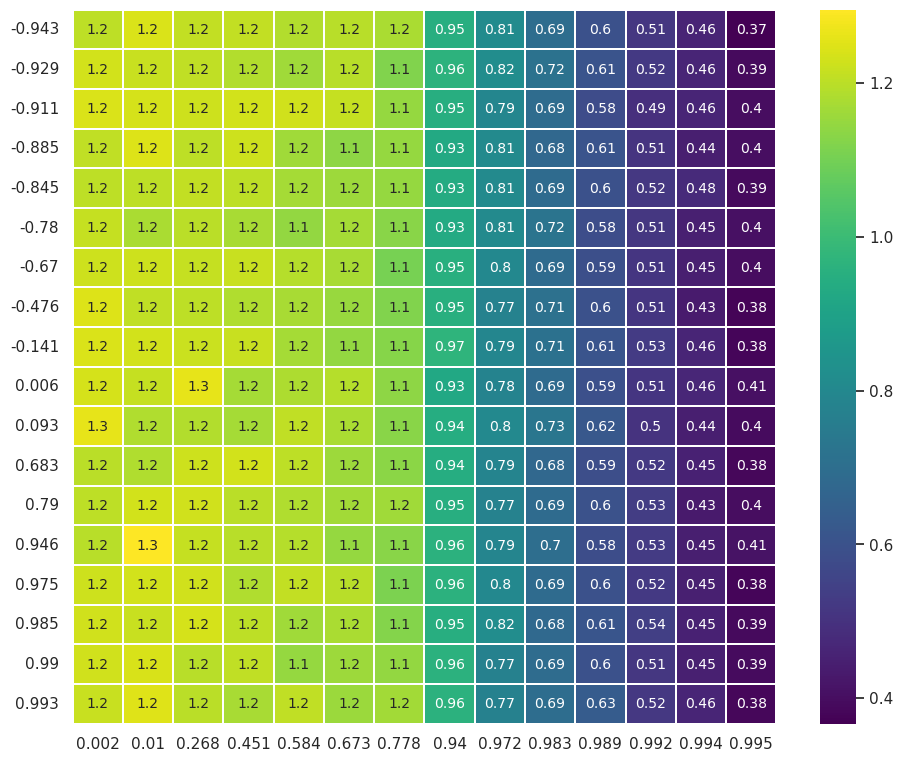

In [179]:
sns.set_theme(style='whitegrid', font='DejaVu Sans')

f, ax = plt.subplots(figsize=(10, 8))

nrmse_heatmap_data = results_data_noise_df.pivot(values='nrmse', columns='noise_moran_', index='data_moran_')

sns.heatmap(nrmse_heatmap_data, annot=True, cmap='viridis', linewidths=0.2, annot_kws={'fontsize': 10}, ax=ax)

plt.tight_layout()
ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('')

plt.savefig('./data_noise_results_std/results_nrmse_heatmap.pdf', dpi=300, bbox_inches='tight')

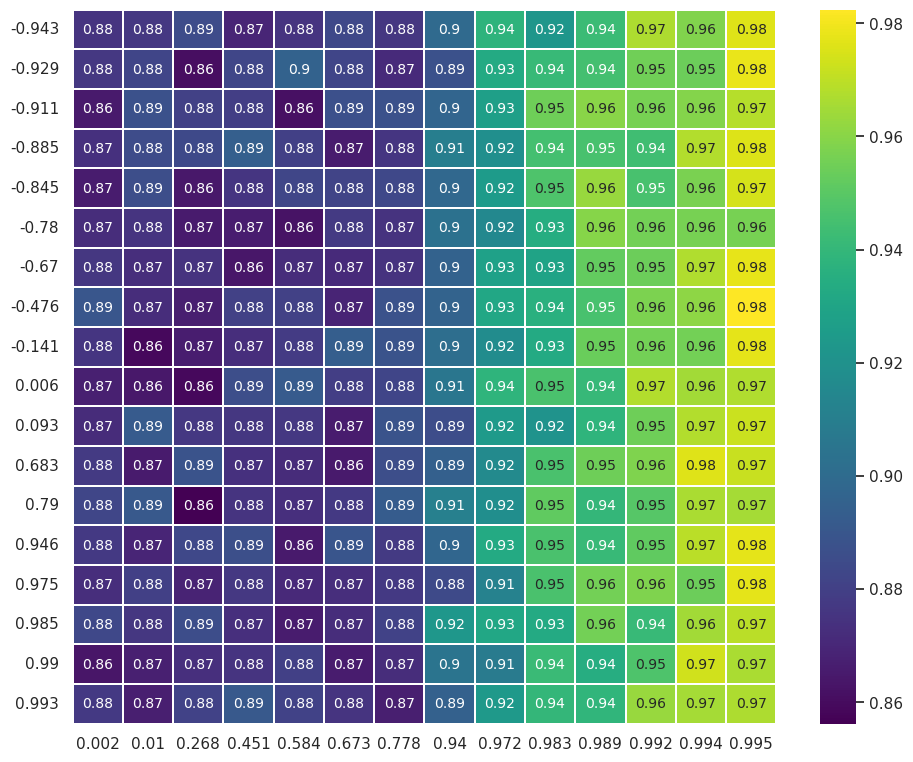

In [183]:
sns.set_theme(style='whitegrid', font='DejaVu Sans')

plt.rcParams['font.family'] = 'Dejavu Sans'

f, ax = plt.subplots(figsize=(10, 8))

cover_heatmap_data = results_data_noise_df.pivot(values='coverage_rate', columns='noise_moran_', index='data_moran_')

sns.heatmap(cover_heatmap_data, annot=True, cmap='viridis', linewidths=0.2, annot_kws={'fontsize': 10}, ax=ax,
            vmax=results_data_noise_df['coverage_rate'].max(), vmin=results_data_noise_df['coverage_rate'].min())

plt.tight_layout()

ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./data_noise_results_std/results_cover_heatmap.pdf', dpi=300, bbox_inches='tight')

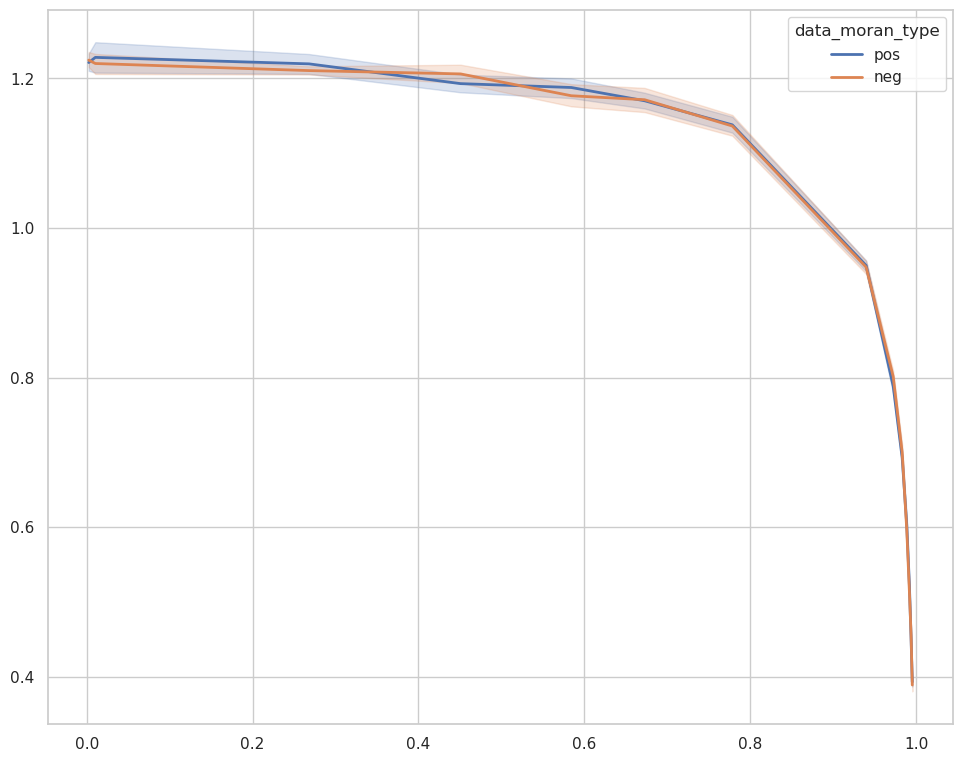

In [181]:
sns.set_theme(style='whitegrid', font='DejaVu Sans')

plt.rcParams['font.family'] = 'Dejavu Sans'

f, ax = plt.subplots(figsize=(10, 8))

sns.lineplot(results_data_noise_df, x='noise_moran', y='nrmse', hue='data_moran_type', ax=ax, lw=2)

plt.tight_layout()

ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('')

plt.savefig('./data_noise_results_std/summary_nrmse_lineplot.pdf', dpi=300, bbox_inches='tight')

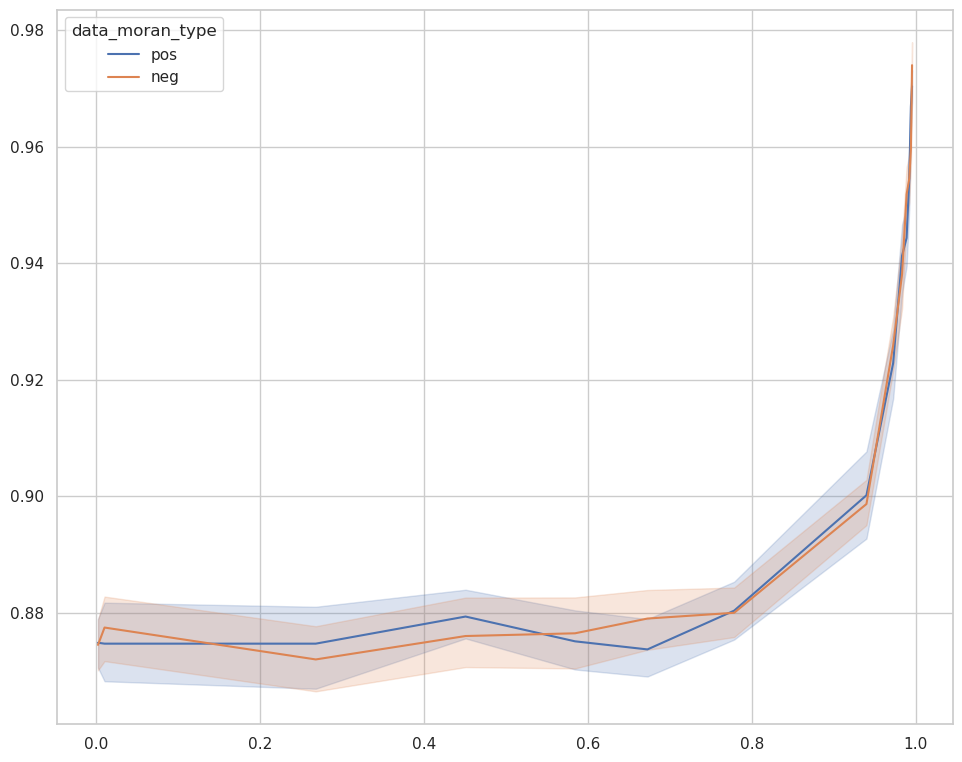

In [182]:
sns.set_theme(style='whitegrid', font='DejaVu Sans')

plt.rcParams['font.family'] = 'Dejavu Sans'

f, ax = plt.subplots(figsize=(10, 8))

sns.lineplot(results_data_noise_df, x='noise_moran', y='coverage_rate', hue='data_moran_type', ax=ax)

plt.tight_layout()

ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('')

plt.savefig('./data_noise_results_std/summary_cover_lineplot.pdf', dpi=300, bbox_inches='tight')

In [132]:
data_moran_types = ['pos', 'neg']
postive_data_sigmas = [0.2, 0.4, 0.8, 1, 2, 3, 4, 5, 6]
negative_data_sigmas = [2, 3, 4, 5, 6, 7, 8, 9, 10]

results_data_noise = []

for data_moran_type in data_moran_types:
    noise = np.zeros((100, 100))
    print(data_moran_type)
    if data_moran_type == 'pos':
        true_model_predict_ = lambda x_, s: true_model_predict(x_, sigma=s)
        biased_model_predict_ = lambda x_, s: biased_model_predict(x_, noise, sigma=s)
        data_sigmas = postive_data_sigmas
    elif data_moran_type == 'neg':
        true_model_predict_ = lambda x_, s: true_model_neg_predict(x_, sigma=s, k=1)
        biased_model_predict_ = lambda x_, s: biased_model_neg_predict(x_, noise, sigma=s, k=1)
        data_sigmas = negative_data_sigmas
    for data_sigma in data_sigmas:
        true_y = true_model_predict_(X_coords, data_sigma)
        X_train, X_temp, true_y_train, true_y_temp, biased_y_train, biased_y_temp, loc_train, loc_temp = train_test_split(
            X_coords, true_y, biased_y, loc, train_size=0.8)
        X_calib, X_test, true_y_calib, true_y_test, biased_y_calib, biased_y_test, loc_calib, loc_test = train_test_split(
            X_temp, true_y_temp, biased_y_temp, loc_temp, train_size=0.5)
        geocp_spatial_biased = GeoConformalSpatialRegression(
            predict_f=lambda x_: biased_model_predict_(x_, data_sigma), nonconformity_score_f=None,
            miscoverage_level=0.1, bandwidth=3, coord_calib=loc_calib.values, coord_test=loc.values,
            X_calib=X_calib, y_calib=true_y_calib, X_test=X_coords, y_test=true_y)
        results_biased = geocp_spatial_biased.analyze()
        results_geo_biased = results_biased.to_gpd()
        geo_uncertainty = results_geo_biased.geo_uncertainty
        geo_uncertainty = geo_uncertainty.values.reshape(100, 100)
        coverage_rate = results_biased.coverage_probability
        fig, axes = plt.subplots(1, 4, dpi=300, figsize=(16, 4))
        ax1, ax2, ax3, ax4 = axes
        ax1.grid(False)
        ax2.grid(False)
        ax3.grid(False)
        ax4.grid(False)
        c1 = ax1.imshow(true_y.reshape(100, 100), cmap='coolwarm')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        cb1 = fig.colorbar(c1, ax=ax1, shrink=0.5)
        cb1.ax.tick_params(labelsize=8)
        c2 = ax2.imshow(geo_uncertainty, cmap='coolwarm')
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])
        cb2 = fig.colorbar(c2, ax=ax2, shrink=0.5)
        cb2.ax.tick_params(labelsize=8)
        c3 = ax3.imshow(noise, cmap='coolwarm')
        ax3.set_xticklabels([])
        ax3.set_yticklabels([])
        cb3 = fig.colorbar(c3, ax=ax3, shrink=0.5)
        cb3.ax.tick_params(labelsize=8)
        noise_abs = np.abs(noise)
        c4 = ax4.imshow(np.abs(noise), cmap='coolwarm')
        ax4.set_xticklabels([])
        ax4.set_yticklabels([])
        cb4 = fig.colorbar(c4, ax=ax4, shrink=0.5)
        cb4.ax.tick_params(labelsize=8)
        noise_moran_i = compute_moran(noise)
        data_moran_i = compute_moran(true_y.reshape(100, 100))
        rmse = root_mean_squared_error(noise_abs, geo_uncertainty)
        mape = rmse  # mean_absolute_percentage_error(noise_abs, geo_uncertainty)
        norm_rmse = rmse  # / (true_y.max() - true_y.min())
        corr = np.corrcoef(noise_abs.flatten(), geo_uncertainty.flatten())[0, 1]
        ssim = structural_similarity(noise_abs, geo_uncertainty, data_range=noise_abs.max() - noise_abs.min())
        plt.tight_layout()
        fig.suptitle(
            f'RMSE: {rmse:.4f}, NRMSE: {norm_rmse:.4f}, corr: {corr:.4f}, ssim: {ssim:.4f}, data_moran: {data_moran_i:.4f}, noise_moran: {noise_moran_i:.4f}, coverage rate: {coverage_rate:.4f}')
        results_data_noise.append(
            [data_moran_type, noise_moran_i, data_moran_i, rmse, corr, ssim, coverage_rate, mape, norm_rmse])
        plt.savefig(
            f'./data_noise_results_metrics_true/{data_moran_type}_data_moran_{data_sigma}.pdf',
            dpi=300)
        plt.close()

pos


C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\esda\moran.py:258: RuntimeWarning: invalid value encountered in scalar divide
  k = k_num / k_den
C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\esda\moran.py:270: RuntimeWarning: invalid value encountered in scalar divide
  return self.n / s0 * inum / self.z2ss
C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\esda\moran.py:227: RuntimeWarning: invalid value encountered in divide
  self.z /= sy
C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\skimage\metrics\_structural_similarity.py:269: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\esda\moran.py:258: RuntimeWarning: invalid value encountered in

neg


C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\esda\moran.py:258: RuntimeWarning: invalid value encountered in scalar divide
  k = k_num / k_den
C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\esda\moran.py:270: RuntimeWarning: invalid value encountered in scalar divide
  return self.n / s0 * inum / self.z2ss
C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\esda\moran.py:227: RuntimeWarning: invalid value encountered in divide
  self.z /= sy
C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\skimage\metrics\_structural_similarity.py:269: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\esda\moran.py:258: RuntimeWarning: invalid value encountered in

In [41]:
from functools import partial

pos



  0%|          | 0/10000 [00:00<?, ?it/s]

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

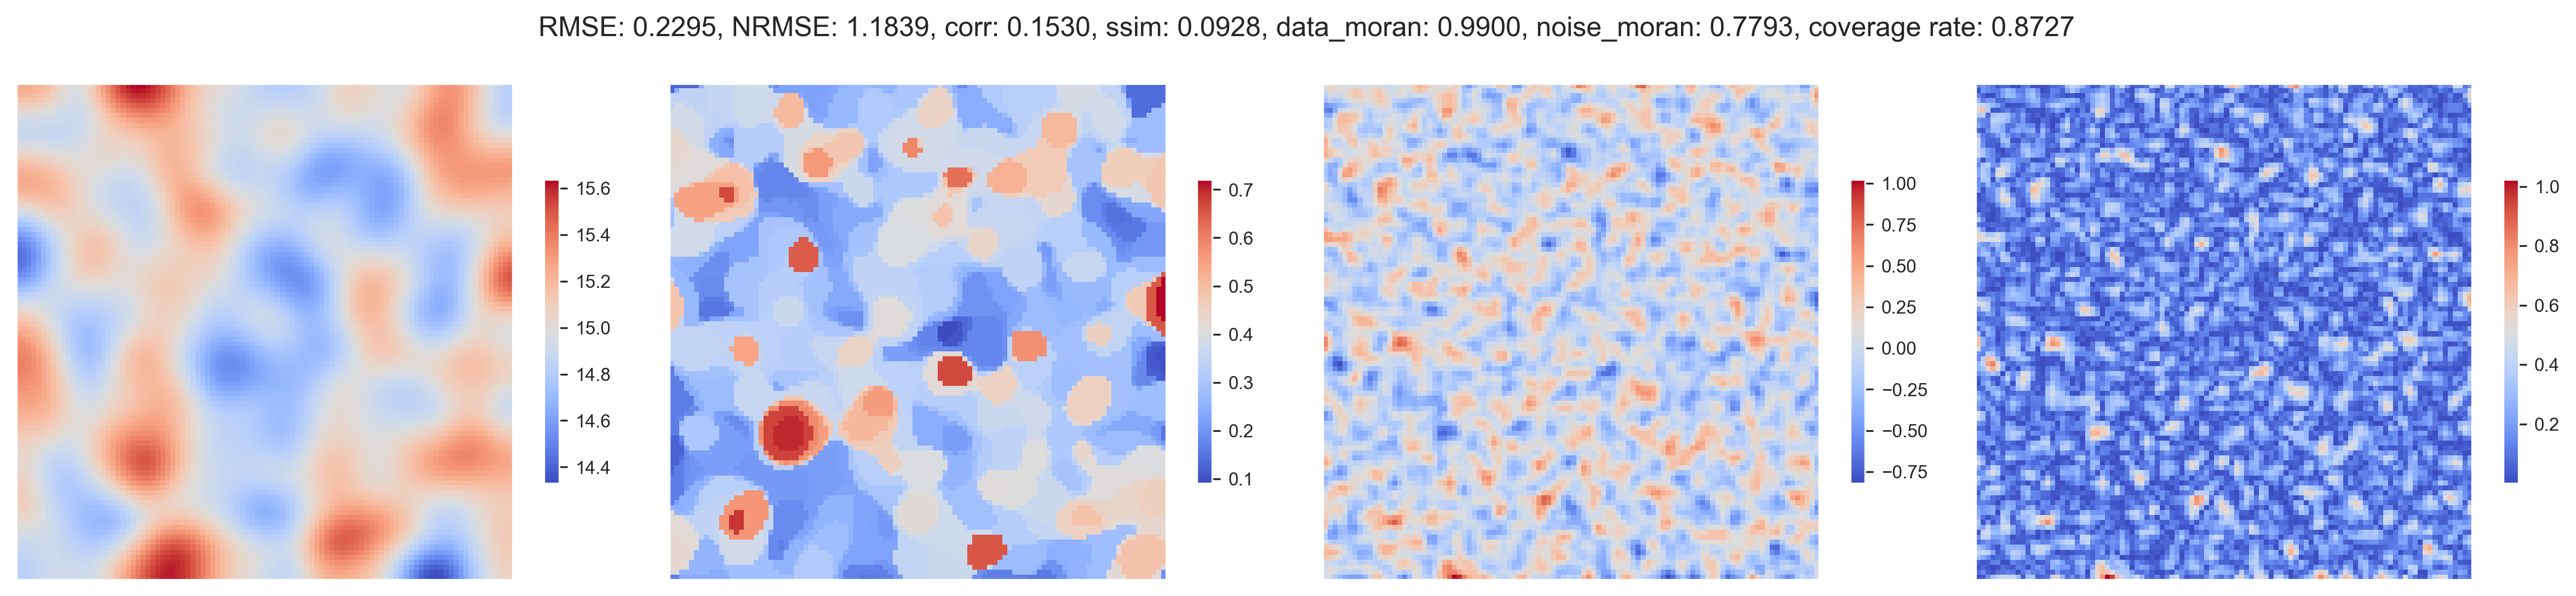

In [55]:
data_moran_types = ['pos', 'neg']
postive_data_sigmas = [5]
negative_data_sigmas = [6]
noise_sigmas = [1, 2, 8]
noise = generate_noise(5)
results_data_noise = []

for data_moran_type in data_moran_types:
    print(data_moran_type)
    for noise_sigma in noise_sigmas:
        noise = generate_noise(noise_sigma)
        if data_moran_type == 'pos':
            true_model_predict_ = lambda x_, s: true_model_predict(x_, sigma=s)
            biased_model_predict_ = lambda x_, s: biased_model_predict(x_, noise, sigma=s)
            data_sigmas = postive_data_sigmas
        elif data_moran_type == 'neg':
            true_model_predict_ = lambda x_, s: true_model_neg_predict(x_, sigma=s, k=1)
            biased_model_predict_ = lambda x_, s: biased_model_neg_predict(x_, noise, sigma=s, k=1)
            data_sigmas = negative_data_sigmas

        X_train, X_temp, true_y_train, true_y_temp, biased_y_train, biased_y_temp, loc_train, loc_temp = train_test_split(
            X_coords, true_y, biased_y, loc, train_size=0.8)
        X_calib, X_test, true_y_calib, true_y_test, biased_y_calib, biased_y_test, loc_calib, loc_test = train_test_split(
            X_temp, true_y_temp, biased_y_temp, loc_temp, train_size=0.5)

        for data_sigma in data_sigmas:
            true_y = true_model_predict_(X_coords, data_sigma)
            geocp_spatial_biased = GeoConformalSpatialRegression(
                predict_f=lambda x_: biased_model_predict_(x_, data_sigma), nonconformity_score_f=None,
                miscoverage_level=0.1, bandwidth=3, coord_calib=loc_calib.values, coord_test=loc.values,
                X_calib=X_calib, y_calib=true_y_calib, X_test=X_coords, y_test=true_y)
            results_biased = geocp_spatial_biased.analyze()
            results_geo_biased = results_biased.to_gpd()
            geo_uncertainty = results_geo_biased.geo_uncertainty
            geo_uncertainty = geo_uncertainty.values.reshape(100, 100)
            coverage_rate = results_biased.coverage_probability
            fig, axes = plt.subplots(1, 4, dpi=300, figsize=(16, 4))
            ax1, ax2, ax3, ax4 = axes
            ax1.grid(False)
            ax2.grid(False)
            ax3.grid(False)
            ax4.grid(False)
            c1 = ax1.imshow(true_y.reshape(100, 100), cmap='coolwarm')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            cb1 = fig.colorbar(c1, ax=ax1, shrink=0.5)
            cb1.ax.tick_params(labelsize=8)
            c2 = ax2.imshow(geo_uncertainty, cmap='coolwarm')
            ax2.set_xticklabels([])
            ax2.set_yticklabels([])
            cb2 = fig.colorbar(c2, ax=ax2, shrink=0.5)
            cb2.ax.tick_params(labelsize=8)
            c3 = ax3.imshow(noise, cmap='coolwarm')
            ax3.set_xticklabels([])
            ax3.set_yticklabels([])
            cb3 = fig.colorbar(c3, ax=ax3, shrink=0.5)
            cb3.ax.tick_params(labelsize=8)
            noise_abs = np.abs(noise)
            c4 = ax4.imshow(np.abs(noise), cmap='coolwarm')
            ax4.set_xticklabels([])
            ax4.set_yticklabels([])
            cb4 = fig.colorbar(c4, ax=ax4, shrink=0.5)
            cb4.ax.tick_params(labelsize=8)
            noise_moran_i = compute_moran(noise)
            data_moran_i = compute_moran(true_y.reshape(100, 100))
            rmse = root_mean_squared_error(noise_abs, geo_uncertainty)
            norm_noise_abs = (noise_abs - noise_abs.mean()) / noise_abs.std()
            norm_geo_uncertainty = (geo_uncertainty - geo_uncertainty.mean()) / noise_abs.std()
            nrmse = root_mean_squared_error(norm_noise_abs, norm_geo_uncertainty)
            mape = mean_absolute_percentage_error(noise_abs, geo_uncertainty)
            norm_rmse = rmse / (noise_abs.max() - noise_abs.min())
            corr = np.corrcoef(noise_abs.flatten(), geo_uncertainty.flatten())[0, 1]
            ssim = structural_similarity(noise_abs, geo_uncertainty, data_range=noise_abs.max() - noise_abs.min())
            plt.tight_layout()
            fig.suptitle(
                f'RMSE: {rmse:.4f}, NRMSE: {nrmse:.4f}, corr: {corr:.4f}, ssim: {ssim:.4f}, data_moran: {data_moran_i:.4f}, noise_moran: {noise_moran_i:.4f}, coverage rate: {coverage_rate:.4f}')
            results_data_noise.append(
                [data_moran_type, noise_moran_i, data_moran_i, rmse, corr, ssim, coverage_rate, mape, nrmse])
            plt.savefig(
                f'./comparison/GeoCP/{data_moran_type}_noise_sigma_{noise_sigma}_data_moran_{data_sigma}.pdf',
                dpi=300)

        for data_sigma in data_sigmas:
            true_y = true_model_predict_(X_coords, data_sigma)
            if data_moran_type == 'pos':
                biased_model_predict_ = partial(biased_model_predict_re, noise, data_sigma)
            elif data_moran_type == 'neg':
                biased_model_predict_ = partial(biased_model_neg_predict_re, noise, 1, data_sigma)
            geocp_spatial_biased = LSCP(
                predict_f=biased_model_predict_, nonconformity_score_f=None,
                miscoverage_level=0.1, k=10, coord_calib=loc_calib.values, coord_test=loc.values,
                x_calib=X_calib, y_calib=true_y_calib, x_test=X_coords, y_test=true_y)
            results_biased = geocp_spatial_biased.analyze()
            results_geo_biased = results_biased.to_gpd()
            geo_uncertainty = results_geo_biased.geo_uncertainty
            geo_uncertainty = geo_uncertainty.values.reshape(100, 100)
            coverage_rate = results_biased.coverage_probability
            fig, axes = plt.subplots(1, 4, dpi=300, figsize=(16, 4))
            ax1, ax2, ax3, ax4 = axes
            ax1.grid(False)
            ax2.grid(False)
            ax3.grid(False)
            ax4.grid(False)
            c1 = ax1.imshow(true_y.reshape(100, 100), cmap='coolwarm')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            cb1 = fig.colorbar(c1, ax=ax1, shrink=0.5)
            cb1.ax.tick_params(labelsize=8)
            c2 = ax2.imshow(geo_uncertainty, cmap='coolwarm')
            ax2.set_xticklabels([])
            ax2.set_yticklabels([])
            cb2 = fig.colorbar(c2, ax=ax2, shrink=0.5)
            cb2.ax.tick_params(labelsize=8)
            c3 = ax3.imshow(noise, cmap='coolwarm')
            ax3.set_xticklabels([])
            ax3.set_yticklabels([])
            cb3 = fig.colorbar(c3, ax=ax3, shrink=0.5)
            cb3.ax.tick_params(labelsize=8)
            noise_abs = np.abs(noise)
            c4 = ax4.imshow(np.abs(noise), cmap='coolwarm')
            ax4.set_xticklabels([])
            ax4.set_yticklabels([])
            cb4 = fig.colorbar(c4, ax=ax4, shrink=0.5)
            cb4.ax.tick_params(labelsize=8)
            noise_moran_i = compute_moran(noise)
            data_moran_i = compute_moran(true_y.reshape(100, 100))
            rmse = root_mean_squared_error(noise_abs, geo_uncertainty)
            norm_noise_abs = (noise_abs - noise_abs.mean()) / noise_abs.std()
            norm_geo_uncertainty = (geo_uncertainty - geo_uncertainty.mean()) / noise_abs.std()
            nrmse = root_mean_squared_error(norm_noise_abs, norm_geo_uncertainty)
            mape = mean_absolute_percentage_error(noise_abs, geo_uncertainty)
            norm_rmse = rmse / (noise_abs.max() - noise_abs.min())
            corr = np.corrcoef(noise_abs.flatten(), geo_uncertainty.flatten())[0, 1]
            ssim = structural_similarity(noise_abs, geo_uncertainty, data_range=noise_abs.max() - noise_abs.min())
            plt.tight_layout()
            fig.suptitle(
                f'RMSE: {rmse:.4f}, NRMSE: {nrmse:.4f}, corr: {corr:.4f}, ssim: {ssim:.4f}, data_moran: {data_moran_i:.4f}, noise_moran: {noise_moran_i:.4f}, coverage rate: {coverage_rate:.4f}')
            results_data_noise.append(
                [data_moran_type, noise_moran_i, data_moran_i, rmse, corr, ssim, coverage_rate, mape, nrmse])
            plt.savefig(
                f'./comparison/LSCP/{data_moran_type}_noise_sigma_{noise_sigma}_data_moran_{data_sigma}.pdf',
                dpi=300)
            plt.close()

In [84]:
noise = generate_noise(5)

In [85]:
def true_model_predict(X, sigma=6):
    smoothed_values = gaussian_filter(base_values, sigma=sigma)
    if isinstance(X, pd.DataFrame):
        X = X.values
    u = X[:, -1].astype(int)
    v = X[:, -2].astype(int)
    return smoothed_values[u, v]

In [86]:
def biased_model_predict(X, sigma=6):
    smoothed_values = gaussian_filter(base_values, sigma=sigma) + noise
    if isinstance(X, pd.DataFrame):
        X = X.values
    u = X[:, -1].astype(int)
    v = X[:, -2].astype(int)
    return smoothed_values[u, v]

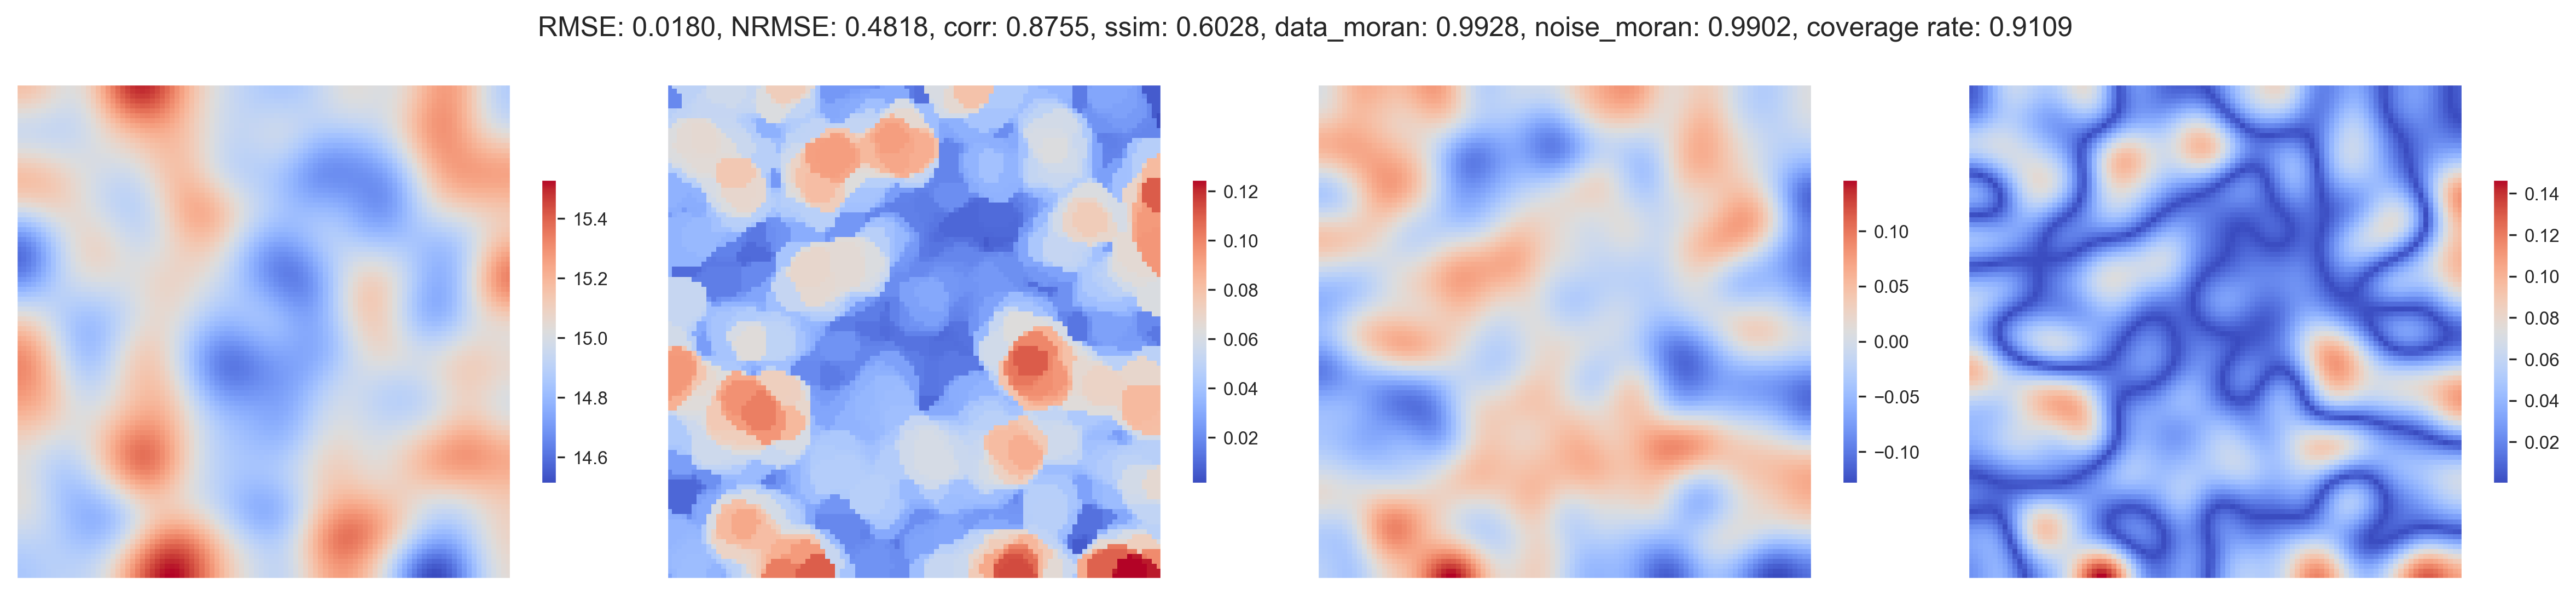

In [87]:
true_y = true_model_predict(X_coords)
X_train, X_temp, true_y_train, true_y_temp, biased_y_train, biased_y_temp, loc_train, loc_temp = train_test_split(
    X_coords, true_y, biased_y, loc, train_size=0.8)
X_calib, X_test, true_y_calib, true_y_test, biased_y_calib, biased_y_test, loc_calib, loc_test = train_test_split(
    X_temp, true_y_temp, biased_y_temp, loc_temp, train_size=0.5)

geocp_spatial_biased = GeoConformalSpatialRegression(
    predict_f=biased_model_predict, nonconformity_score_f=None,
    miscoverage_level=0.1, bandwidth=2, coord_calib=loc_calib.values, coord_test=loc.values,
    X_calib=X_calib, y_calib=true_y_calib, X_test=X_coords, y_test=true_y)
results_biased = geocp_spatial_biased.analyze()
results_geo_biased = results_biased.to_gpd()
geo_uncertainty = results_geo_biased.geo_uncertainty
geo_uncertainty = geo_uncertainty.values.reshape(100, 100)
coverage_rate = results_biased.coverage_probability
fig, axes = plt.subplots(1, 4, dpi=300, figsize=(16, 4))
ax1, ax2, ax3, ax4 = axes
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)
ax4.grid(False)
c1 = ax1.imshow(true_y.reshape(100, 100), cmap='coolwarm')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
cb1 = fig.colorbar(c1, ax=ax1, shrink=0.5)
cb1.ax.tick_params(labelsize=8)
c2 = ax2.imshow(geo_uncertainty, cmap='coolwarm')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
cb2 = fig.colorbar(c2, ax=ax2, shrink=0.5)
cb2.ax.tick_params(labelsize=8)
c3 = ax3.imshow(noise, cmap='coolwarm')
ax3.set_xticklabels([])
ax3.set_yticklabels([])
cb3 = fig.colorbar(c3, ax=ax3, shrink=0.5)
cb3.ax.tick_params(labelsize=8)
noise_abs = np.abs(noise)
c4 = ax4.imshow(np.abs(noise), cmap='coolwarm')
ax4.set_xticklabels([])
ax4.set_yticklabels([])
cb4 = fig.colorbar(c4, ax=ax4, shrink=0.5)
cb4.ax.tick_params(labelsize=8)
noise_moran_i = compute_moran(noise)
data_moran_i = compute_moran(true_y.reshape(100, 100))
rmse = root_mean_squared_error(noise_abs, geo_uncertainty)
norm_noise_abs = (noise_abs - noise_abs.mean()) / noise_abs.std()
norm_geo_uncertainty = (geo_uncertainty - geo_uncertainty.mean()) / noise_abs.std()
nrmse = root_mean_squared_error(norm_noise_abs, norm_geo_uncertainty)
mape = mean_absolute_percentage_error(noise_abs, geo_uncertainty)
norm_rmse = rmse / (noise_abs.max() - noise_abs.min())
corr = np.corrcoef(noise_abs.flatten(), geo_uncertainty.flatten())[0, 1]
ssim = structural_similarity(noise_abs, geo_uncertainty, data_range=noise_abs.max() - noise_abs.min())
plt.tight_layout()
fig.suptitle(
    f'RMSE: {rmse:.4f}, NRMSE: {nrmse:.4f}, corr: {corr:.4f}, ssim: {ssim:.4f}, data_moran: {data_moran_i:.4f}, noise_moran: {noise_moran_i:.4f}, coverage rate: {coverage_rate:.4f}')
results_data_noise.append(
    [data_moran_type, noise_moran_i, data_moran_i, rmse, corr, ssim, coverage_rate, mape, nrmse])
plt.savefig(
    f'./comparison/GeoCP/{data_moran_type}_noise_sigma_{noise_sigma}_data_moran_{data_sigma}.pdf',
    dpi=300)

In [88]:
true_y = true_model_predict(X_coords)
X_train, X_temp, true_y_train, true_y_temp, biased_y_train, biased_y_temp, loc_train, loc_temp = train_test_split(
    X_coords, true_y, biased_y, loc, train_size=0.8)
X_calib, X_test, true_y_calib, true_y_test, biased_y_calib, biased_y_test, loc_calib, loc_test = train_test_split(
    X_temp, true_y_temp, biased_y_temp, loc_temp, train_size=0.5)

for data_sigma in data_sigmas:
    geocp_spatial_biased = LSCP(
        predict_f=biased_model_predict, nonconformity_score_f=None,
        miscoverage_level=0.1, k=10, coord_calib=loc_calib.values, coord_test=loc.values,
        x_calib=X_calib, y_calib=true_y_calib, x_test=X_coords, y_test=true_y)
    results_biased = geocp_spatial_biased.analyze()
    results_geo_biased = results_biased.to_gpd()
    geo_uncertainty = results_geo_biased.geo_uncertainty
    geo_uncertainty = geo_uncertainty.values.reshape(100, 100)
    coverage_rate = results_biased.coverage_probability
    fig, axes = plt.subplots(1, 4, dpi=300, figsize=(16, 4))
    ax1, ax2, ax3, ax4 = axes
    ax1.grid(False)
    ax2.grid(False)
    ax3.grid(False)
    ax4.grid(False)
    c1 = ax1.imshow(true_y.reshape(100, 100), cmap='coolwarm')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    cb1 = fig.colorbar(c1, ax=ax1, shrink=0.5)
    cb1.ax.tick_params(labelsize=8)
    c2 = ax2.imshow(geo_uncertainty, cmap='coolwarm')
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    cb2 = fig.colorbar(c2, ax=ax2, shrink=0.5)
    cb2.ax.tick_params(labelsize=8)
    c3 = ax3.imshow(noise, cmap='coolwarm')
    ax3.set_xticklabels([])
    ax3.set_yticklabels([])
    cb3 = fig.colorbar(c3, ax=ax3, shrink=0.5)
    cb3.ax.tick_params(labelsize=8)
    noise_abs = np.abs(noise)
    c4 = ax4.imshow(np.abs(noise), cmap='coolwarm')
    ax4.set_xticklabels([])
    ax4.set_yticklabels([])
    cb4 = fig.colorbar(c4, ax=ax4, shrink=0.5)
    cb4.ax.tick_params(labelsize=8)
    noise_moran_i = compute_moran(noise)
    data_moran_i = compute_moran(true_y.reshape(100, 100))
    rmse = root_mean_squared_error(noise_abs, geo_uncertainty)
    norm_noise_abs = (noise_abs - noise_abs.mean()) / noise_abs.std()
    norm_geo_uncertainty = (geo_uncertainty - geo_uncertainty.mean()) / noise_abs.std()
    nrmse = root_mean_squared_error(norm_noise_abs, norm_geo_uncertainty)
    mape = mean_absolute_percentage_error(noise_abs, geo_uncertainty)
    norm_rmse = rmse / (noise_abs.max() - noise_abs.min())
    corr = np.corrcoef(noise_abs.flatten(), geo_uncertainty.flatten())[0, 1]
    ssim = structural_similarity(noise_abs, geo_uncertainty, data_range=noise_abs.max() - noise_abs.min())
    plt.tight_layout()
    fig.suptitle(
        f'RMSE: {rmse:.4f}, NRMSE: {nrmse:.4f}, corr: {corr:.4f}, ssim: {ssim:.4f}, data_moran: {data_moran_i:.4f}, noise_moran: {noise_moran_i:.4f}, coverage rate: {coverage_rate:.4f}')
    results_data_noise.append(
        [data_moran_type, noise_moran_i, data_moran_i, rmse, corr, ssim, coverage_rate, mape, nrmse])
    plt.savefig(
        f'./comparison/LSCP/{data_moran_type}_noise_sigma_{noise_sigma}_data_moran_{data_sigma}.pdf',
        dpi=300)





  0%|          | 0/10000 [00:00<?, ?it/s]



  0%|          | 8/10000 [00:00<05:31, 30.12it/s]

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.